In [1]:
%matplotlib inline

import sys, os
_utils_dir = os.path.join(os.path.abspath('.'), 'utils')
if _utils_dir not in sys.path:
    sys.path.insert(0, _utils_dir)
    
IMAGES_DIR = os.path.join(os.path.abspath('.'), 'assets')
CAULIFLOWERS_DIR = os.path.join(IMAGES_DIR, 'cauliflowers')
TILINGS_DIR = os.path.join(IMAGES_DIR, 'tilings')
SKYLINES_DIR = os.path.join(IMAGES_DIR, 'skylines')
CAUSTICS_DIR = os.path.join(IMAGES_DIR, 'caustics')

For something to be considered a 'signal', as opposed to just noise, there has to be some redundancy in the data, some relationship between samples which makes one predictable from another.

This is the principle behind compression:

***Find the smallest number of data points that capture as much of the signal variation as possible.***

The approach to doing this that most people are shown first is the <a href="https://en.wikipedia.org/wiki/Fourier_transform">Fourier Transform</a>, whereby signals are expressed as a sum of sinusoids (Figure 0.3).


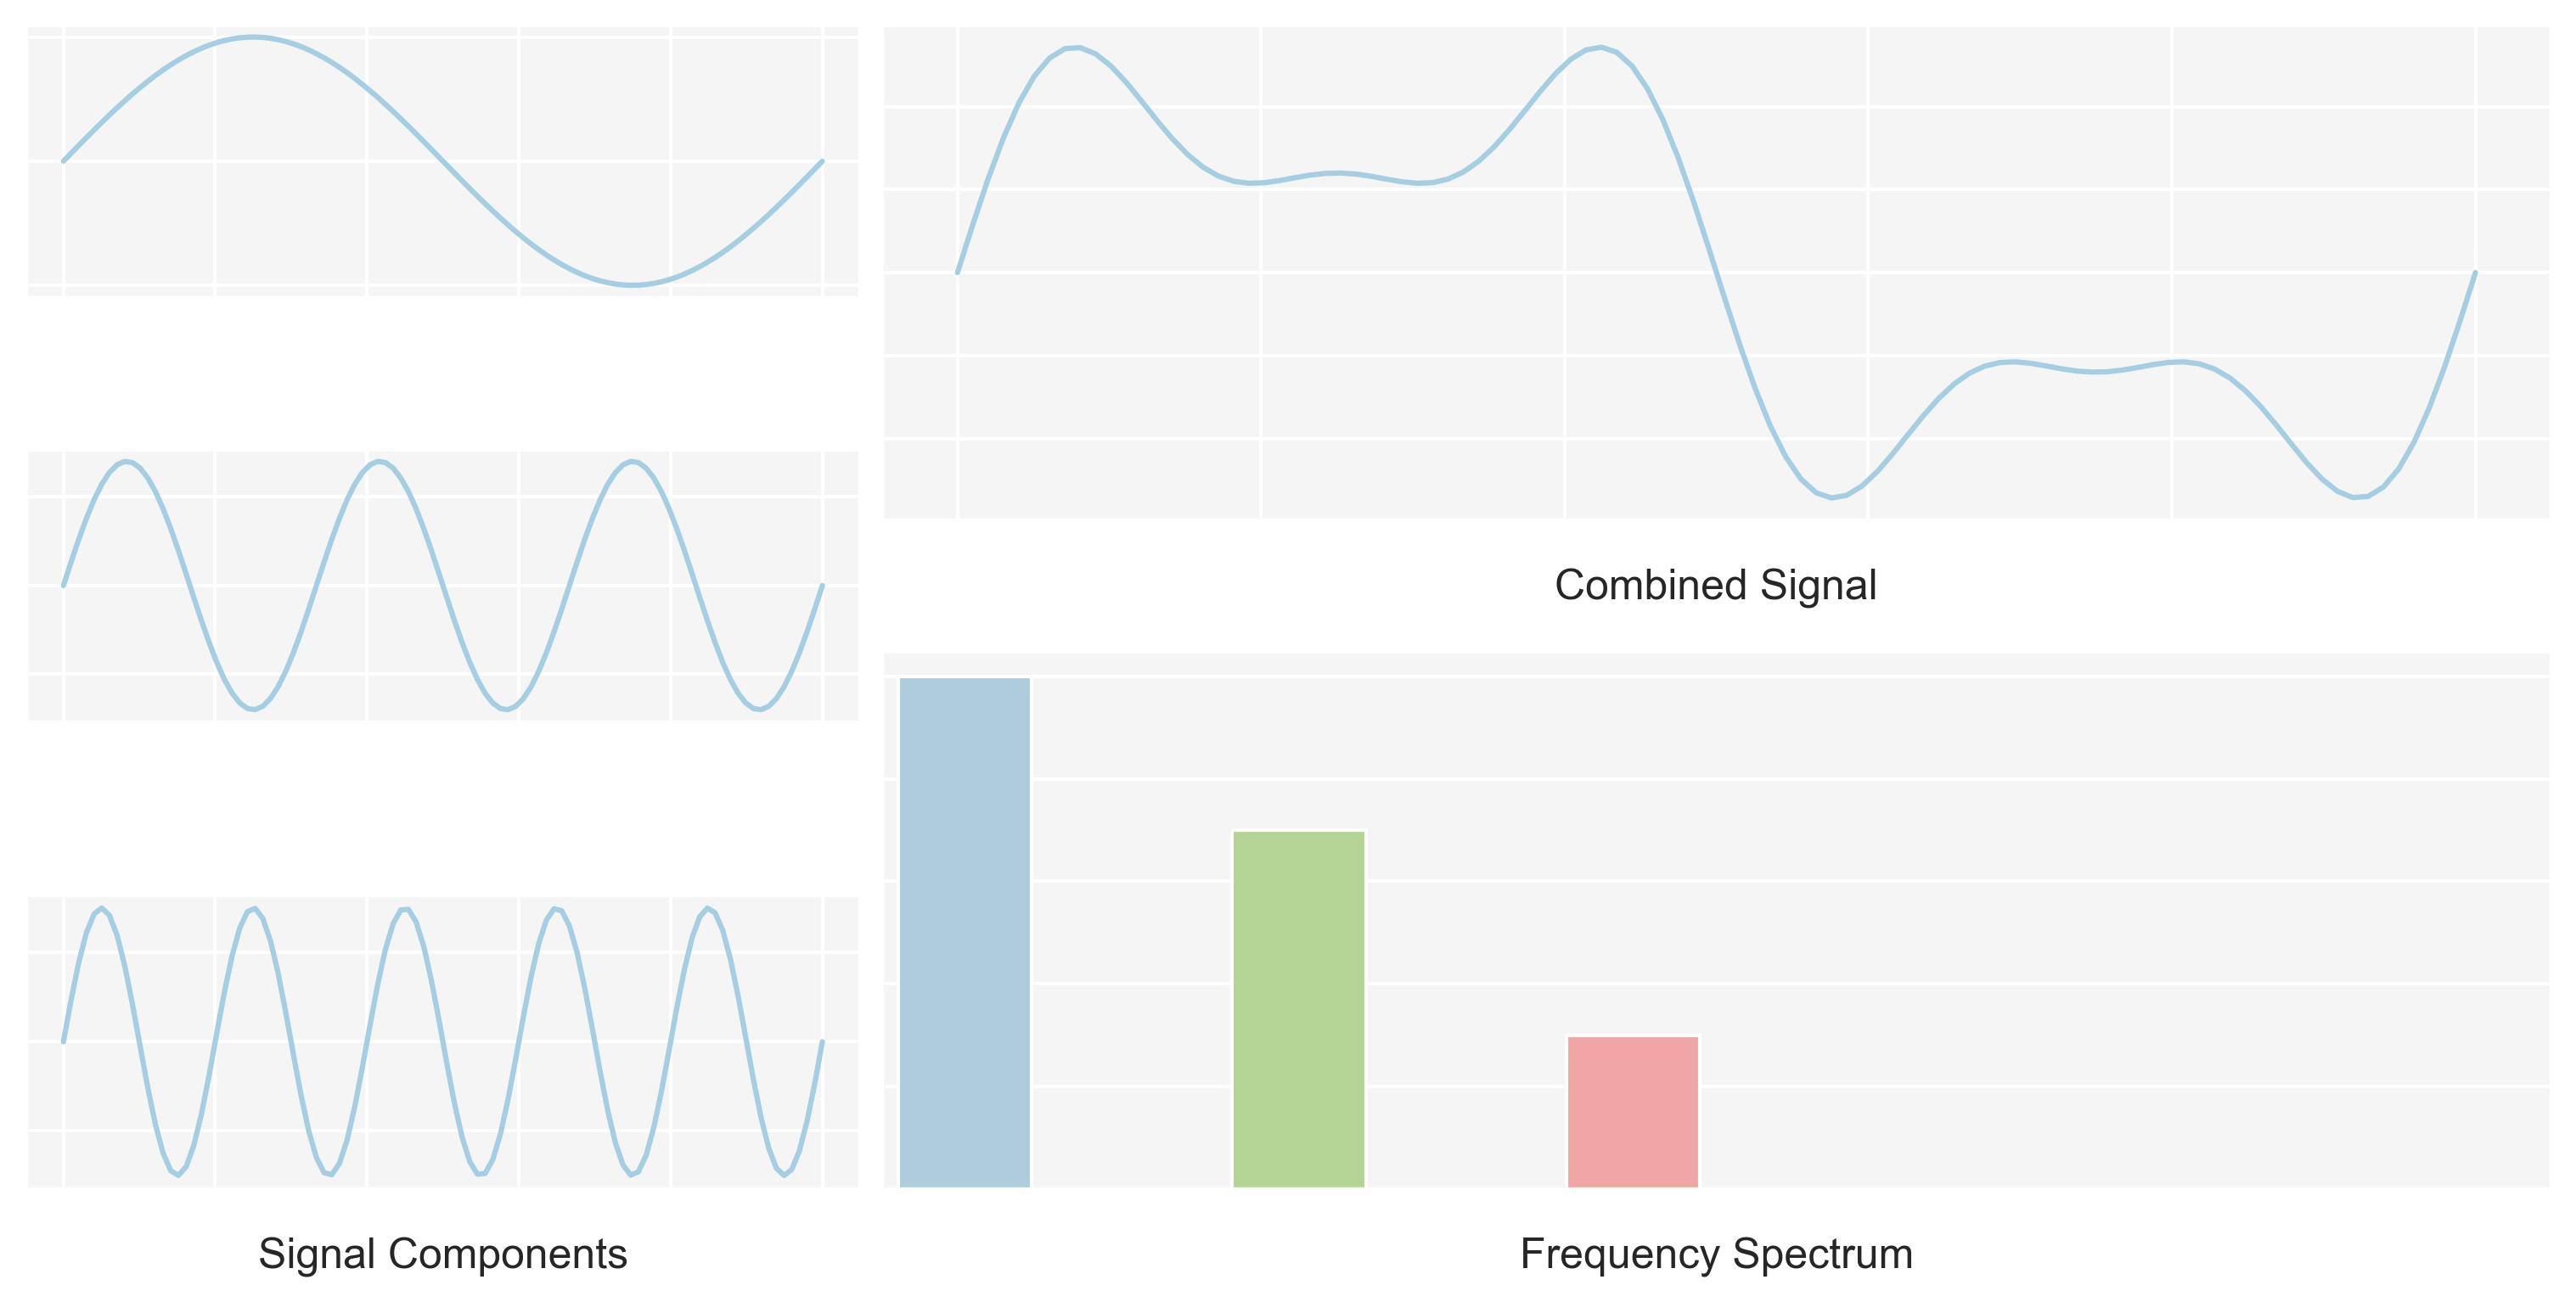

In [2]:
import seaborn as sns
import blogutils
blogutils.init_theme(sns)
fig = blogutils.plot_simple_fourier_decomposition()
blogutils.html_fig(fig, '0.1', 'An illustration of a simple Fourier decomposition of a signal.')

However this is by no means the only, nor the most efficient, way to compress a signal.

For example, if I want to remind you to bring your raincoat tomorrow, I think it's safe to assume that simply sending you a text-based message is going to use far less data than making a voice recording and sending a fourier-compressed copy to you.

What will ultimately determine the most efficient compression basis to use will be the kind of signal you're trying to compress, and the way that the information you care about is contained in that signal. (This is, in effect, the <a href="https://en.wikipedia.org/wiki/No_free_lunch_theorem">'No Free Lunch Theorem'</a> at work).

Choosing the right basis, however, is a non-trivial task.

A mathematical tool which has popped up a few times during my searches this past year is the **Wavelet Transform**; a tool that generalises the process of signal decomposition to allow us to plug in different bases depending on our needs. These pluggable bases are known as 'Wavelets' - some of which are shown in Figure 0.2.


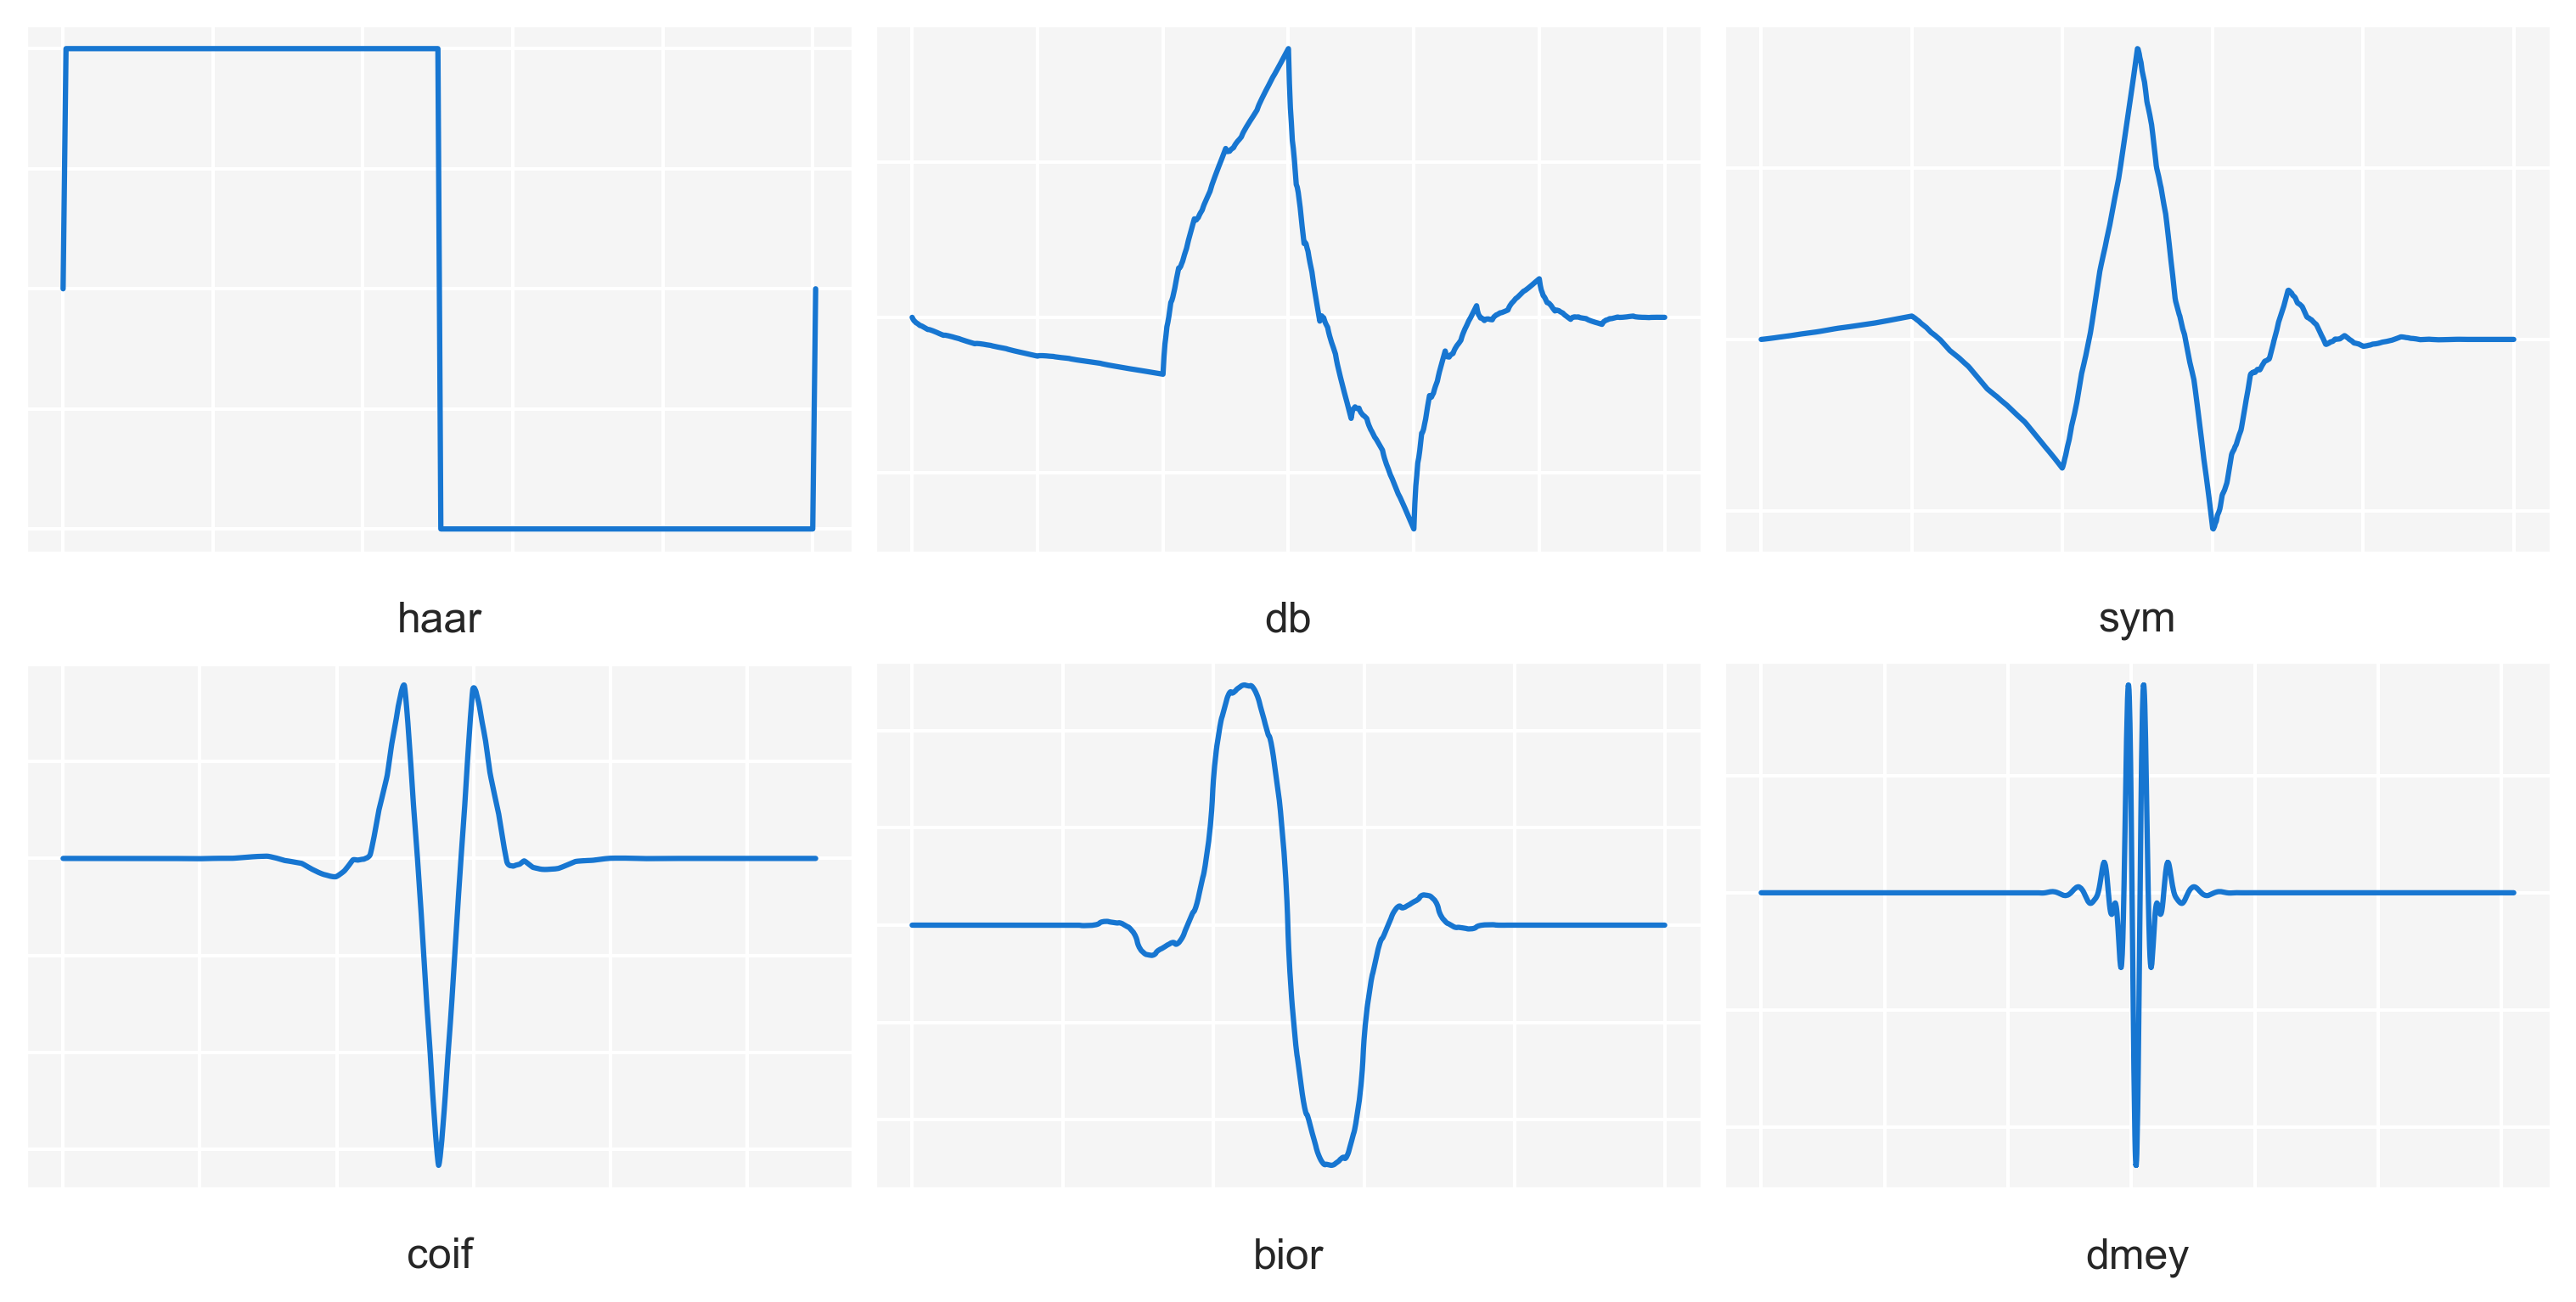

In [3]:
import blogutils
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
import blogutils
blogutils.init_theme(sns)
sns.set_palette(sns.dark_palette('#1776D1', reverse=True))

fams = ['haar', 'db', 'sym', 'coif', 'bior', 'dmey']
fams_per_row = int(len(fams)/2)
fig, ax = plt.subplots(2, fams_per_row, figsize=(10, 5), constrained_layout=True)
for i in range(2):
    for j in range(fams_per_row):
        fam = fams[i*fams_per_row + j]
        fam_len = len(pywt.wavelist(fam))
        fam_idx = min(1, fam_len-1)
        dbwv = pywt.Wavelet(pywt.wavelist(fam)[fam_idx])
        dbwv_fun = dbwv.wavefun()
        ax[i][j].set_xlabel(fam);
        ax[i][j].set_xticklabels([]);
        ax[i][j].set_yticklabels([]);
        sns.lineplot(x=dbwv_fun[-1], y=dbwv_fun[1], ax=ax[i][j]);

blogutils.html_fig(fig, '0.2', 'Some of the different wavelet bases.')

However, all of this variety makes one wonder ***how should one choose a wavelet basis?***

That's what I'll be exploring in this post.

I'll start by describing - in a very coarse manner - what the wavelet transform does, and then I'll run a simple experiment to see how different wavelet families compare head-to-head on a few different image categories.

## Part 1: A quick overview of the wavelet transform

While early forms of the wavelet transform concept date back to the start of the 1900s, the modern notion of the concept as a standardized, textbook-ready, tool is attributed to the work of Morlet and Grossmann in the 1970s <cite>(Graps, 1995)</cite>[1], <cite>(Daubechies, 1996)</cite>[2].

Morlet was a geophysicist looking to perform signal analysis on seismic data, which contained a fractal-like hierarchy of short-lived vibrations. Using the primary tool available at the time - the <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform">Short-time Fourier transform</a> - you would deal with this kind of data by sliding a windowed wave-form across the signal and record the similarity at each position, thus giving you a sense of similarity in both space and time.

<figure class="nb-diagram" align="center"><img src="assets/sliding_window.png" width="400px"><figcaption>Figure 1.1: Sliding a window in the Short-time Fourier transform. (Source: TeaochaDesign)</figcaption></figure>

Whilst partially effective, this approach fails to acknowledge the different scales of the signal.

If the signal really is indeed fractal-like then by zooming into it we should find a recursively similar level of detail. In other words, our window size should grow/shrink in a dual manner to the frequency scale we're observing.

(As a childish example, think about a scientist with a magnifying glass being shrunk down. The tiny scientist may find that their tiny magnifying glass can be used to study a pebble just as effectively as it was used it to study a boulder back when the scientist was bigger).

This is the essence of what Morlet created. He described a recursive system for decomposing signals: the **Wavelet transform**.

Like the Short-time Fourier-transform there would be a windowed mask that slides over the data looking for pattern similarity - known as the **Wavelet** - however, unlike the STFT, these windows would vary in size to match the fractal-like changes in scale.

The fractal/recursive nature of things is handled in the algorithm by splitting the signal into multiple *resolutions*. The original signal is considered to be the *maximum resolution* of the data, and by passing over that data with a wavelet tuned to that resolution we can match and extract out that high-resolution detail.

With the detail removed, what's left over will be an approximation to the original signal at the next lowest resolution, and the whole process can start again.

A more detailed description of the theory behind this process can be found in <cite>(Mallat, 1989)</cite>[3]. We can view this recursive procedure as a lopsided pyramid (Fig 1.2).

<figure class="nb-diagram" align="center"><img src="assets/compression_pyramid.png" width="600px"><figcaption>Figure 1.2: The tower of wavelet windows and how they correspond to the variation in a signal. (Source: TeaochaDesign)</figcaption></figure>

If we were to repeat this process an infinite number of times we would eventually whittle away at our data until there was nothing left but a steady-state signal, meaning that what has been removed from the signal is a tower of fractally-scaled wavelets. This whittling can be seen in Figure 1.3, in which the 'remainder' of the image is shown at successive steps of a five-level pyramid.


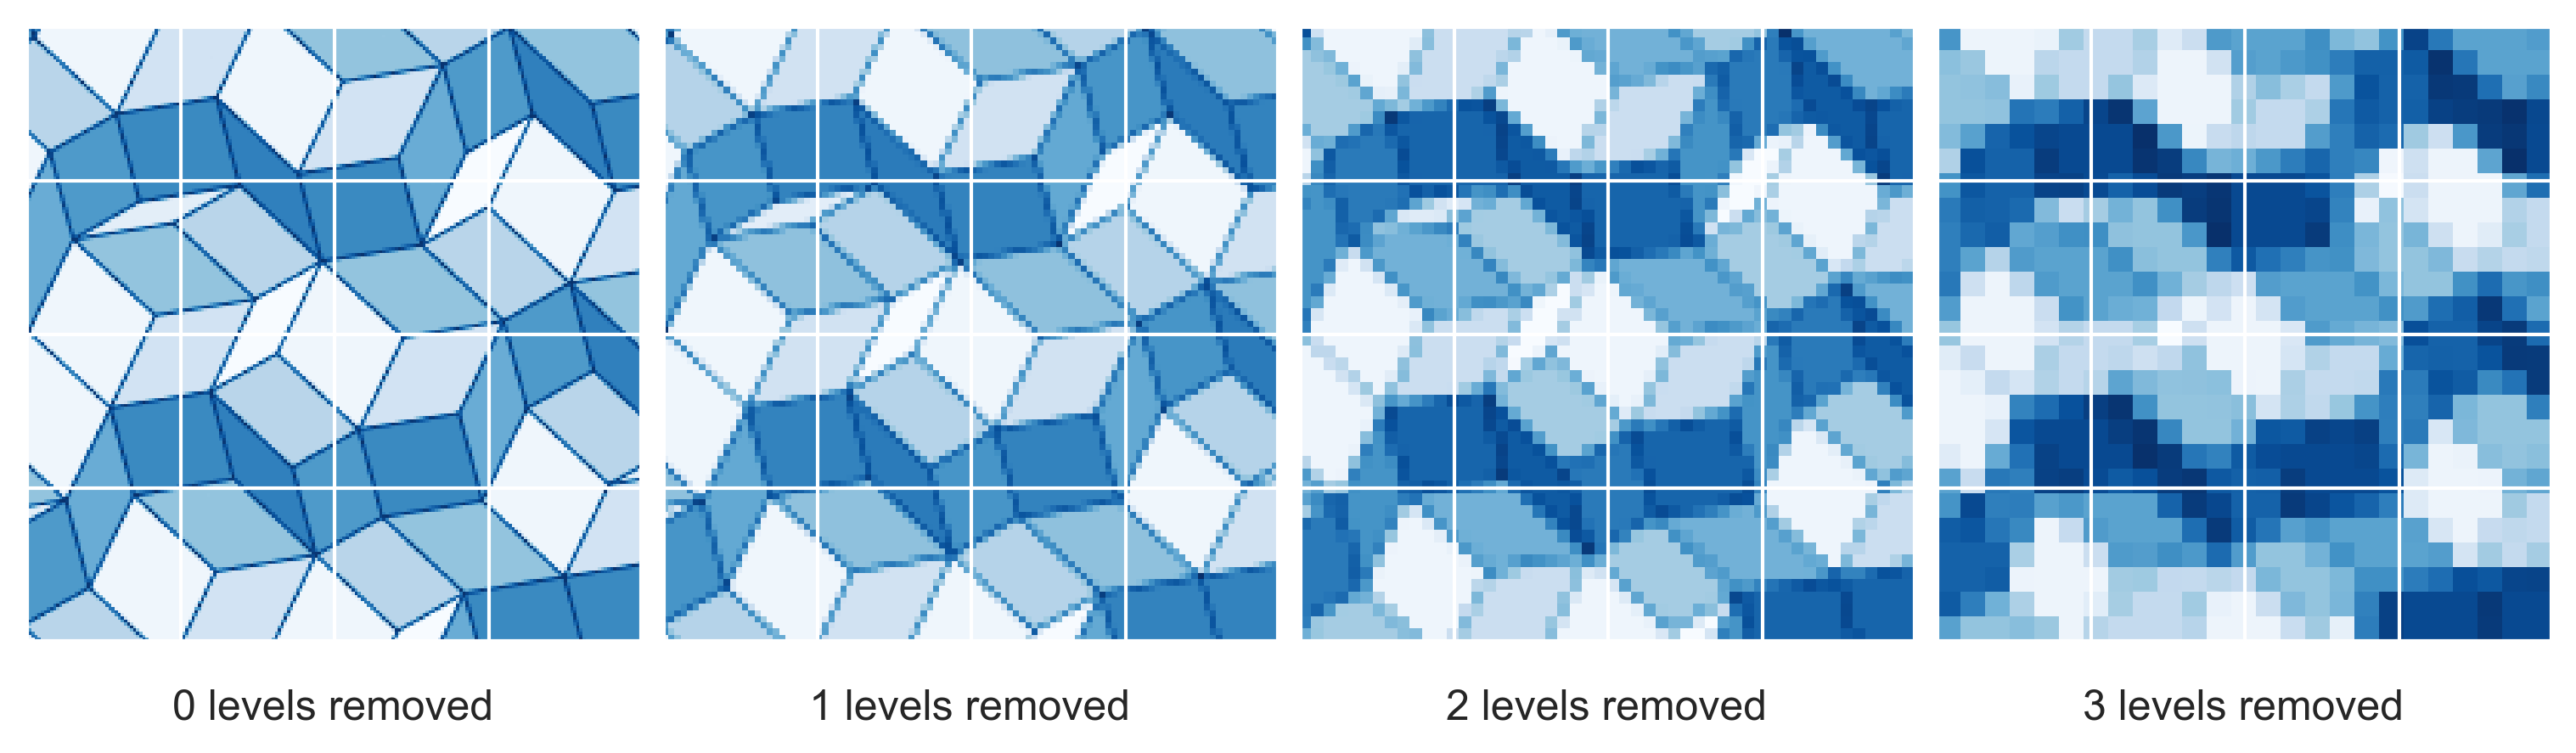

In [4]:
import numpy as np
import blogutils
import pywt

tiling_gen = blogutils.image_bootstrapper(TILINGS_DIR, 0.4, 0.4)
tiling_img = np.array(next(tiling_gen).convert('L'))
tiling_coefs = pywt.wavedec2(tiling_img, 'db1', level=5)

fig, ax = plt.subplots(1, 4, figsize=(10, 3), constrained_layout=True)
for l in range(4):
    _tcoefs = tiling_coefs
    for ll in range(l):
        _tcoefs[-(ll+1)] = [
            np.zeros_like(_tcoefs[-(ll+1)][0])
            for lll in range(len(_tcoefs[-(ll+1)]))
        ]
    tiling_recon = pywt.waverec2(_tcoefs, 'db1')
    ax[l].imshow(tiling_recon, cmap='Blues_r');
    ax[l].set_xticklabels([]);
    ax[l].set_yticklabels([]);
    ax[l].set_xlabel(f'{l} levels removed');

blogutils.html_fig(fig, '1.3', 'An image after successive levels of detail resolution of have been removed via a wavelet transformation - using a Daubechies wavelet')

The wavelet transform then, is ultimately a tool which you would expect to excel at:

- identifying nested structures of signal information
- identifying locally concentrated signal information
- removing detail from signals

These are qualities that motivate a lot of interest in the use of wavelet transforms for image compression and analysis, as images tend to contain subjects at different distances from the observer, or subjects born out of natural processes that have self-similarity at different scales.

## Part 2: Overview of the experiment

I finished the last section by noting how the wavelet transform has garnered interest in the area of image compression. However, in this post, I'm not so much interested in seeing how well the wavelet transform compares against other techniques, but rather how different wavelet shapes compete once we've chosen a specific subject.

As mentioned already, there are a huge range of wavelet shapes to choose from, and so I have no expectation of conducting an exhaustive trial. What I'm more interested in doing is establishing a basic process for testing the differences and getting a small sense of how those differences manifest on a few different types of image.

More concretely, we will have the following variables to deal with:

- **Wavelet family**:
    - <a href="http://wavelets.pybytes.com/wavelet/haar/">Harr</a>
    - <a href="http://wavelets.pybytes.com/wavelet/db2/">Daubechies</a>
    - <a href="http://wavelets.pybytes.com/wavelet/sym2/">Symlets</a>
    - <a href="http://wavelets.pybytes.com/wavelet/coif1/">Coiflets</a>
    - <a href="http://wavelets.pybytes.com/wavelet/bior1.3/">Biorthogonal</a>
    - <a href="http://wavelets.pybytes.com/wavelet/rbior1.3/">Reverse Biorthogonal</a>
    
    (This list matches those shown in Figure 0.2)
    
- **Compression level**
    
    As demonstrated in Figure 1.3, we can compress an image by removing successive levels of detail. The wavelet transform will have five-levels and we will measure results at four levels of compression:
    - 1
    - 2
    - 3
    - 4
    
- **Image category**
    
    I have prepared a small batch of images from four categories:
    - Green Cauliflowers
    - Penrose Tilings
    - Water Caustics
    - City Skylines
    
In order to form any hypotheses using these variables we will need a statistic that can be meaningfully compared.

The statistic I've decided on is the **Total Wavelet Compression Entropy** - or $H_w$. This statistic is not anything widely used, but rather something I've constructed myself for the purpose of this experiment. It is computed as follows:

\begin{equation}
H_w = (1 - \lambda)H_c + (\lambda)H_r
\tag{1}
\label{eq:1}
\end{equation}

Where

- $H_c$ is the ratio of the number of bytes required to save the values of the transformed image to the number of bytes in the total image before transformation - the subscript $c$ standing for *compression*. So it is a measure, per pixel of the image, of the information in wavelet-space.
- $H_r$ is the <a href="https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence">Kullback-Leibler divergence</a> between the original image and the reconstructed image - the subscript $r$ standing for *reconstruction*. It is a measure, per pixel of the image, of the information needed to describe the difference between the original image and the lower resolution approximation.
- $\lambda$ is an arbitrary ratio that captures our preference for maximising reconstruction quality over compression size. For this experiment it will be fixed at $0.8$.

With all variables and scoring statistics now defined, I can state my hypothesis in more objective terms:

<aside class="hypothesis"><span>Hypothesis</span><span>For a given image category, the Total Wavelet Compression Entropy will vary significantly depending on the choice of wavelet family used to compress and reconstruct an image.</span></aside>

This means that we're looking to run some kind of <a href="https://en.wikipedia.org/wiki/Analysis_of_variance">ANOVA</a> study with wavelet family as the primary independent variable and $H_w$ as the dependent variable. Ideally, I would treat this as a Two-Way ANOVA, testing both image category and image family as primary variables, however there are way too many image categories out there for me to run a meaningful study. Instead, I'll just repeat the experiment once for each category as more of an exploratory comparison.

Within each image category I'll also repeat the experiment for each compression-level, however this too will not be a primary variable in the ANOVA.

Thus, the experiment will be run as follows:

- For a given image category (x4):
    - A wavelet family will be selected (x6)
    - A compression-level will be selected (x4)
    - A measurement will be made (x10) in which:
        - An image will be drawn from the given category using bootstrap sampling.
        - The image will be transformed using the wavelet family and compression-level.
        - The transformed image will be byte-encoded using GZip, and the resulting blob will be used to calculate $H_c$.
        - The compressed image will be reconstructed and compared with the original to get $H_r$
        - $H_c$ and $H_r$ will be used to calculate $H_w$
        
<figure class="nb-diagram" align="center"><img src="assets/experiment_flow.png" width="500px"><figcaption>Figure 2.1: A depiction of the experimental flow used to compare compression scores of wavelet families within a given image category. (Source: TeaochaDesign)</figcaption></figure>

With our experiment now defined we can write some code and compute some results.

## Part 3: The Code

First of all, we'll need to set up the environment, and import what we need:

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Personal utils to remove cognitive clutter.
# (See 'https://github.com/teaochablog/comparing-wavelets-for-image-compression/utils')
import blogutils
blogutils.init_theme(sns)

Included in the `blogutils` module are the following helper methods:

- `image_bootstrapper(images_dir: str, x_crop: float, y_crop: float) -> generator`
    
    Given an image directory this creates a sample generator that uses a bootstrap method to return random cropped areas from the images in the directory.
    
- `kl(P: ndarray, Q: ndarray) -> float`
    
    Calculates the KL-Divergence between two numpy arrays - assuming that the two arrays have been normalised as a probability distribution.
    

In addition to the above, we also have methods that will plot the results of the experiment (from a data-frame).
    
With our setup done we can now define an estimator, which will compute wavelet decompositions using the PyWavelets[4] library.

The public methods on estimators usually accept a sample (X value) and a target (Y value), with the idea that you're trying to predict Y from X. In this case though the estimator is acting as an encoder, and so the X value and the Y value will be the same - i.e. the original image is the data we estimate from and also what we measure our predictions against.

In [6]:
import pywt
import gzip
import json
from PIL import Image
from sklearn.base import BaseEstimator, ClassifierMixin

# The following two helper methods are what we'll use to turn
# the wavelet coefficients into a compressed bytestring:

def compress_array(arr, round_to: int=3):
    '''Stringifies a numpy array and then zips it into a bytestring.
    '''
    rounded = np.around(arr, round_to)
    as_string = json.dumps(rounded.tolist())
    compressed = gzip.compress(str.encode(as_string))
    return compressed

def compress_wavelet_coeffs(coeffs):
    '''Takes a list of wavelet coefficients and compresses
    it into a bytestring.
    '''
    cfs_approx = coeffs[0]
    cfs_detail = coeffs[1:]
    compressed = b''
    compressed += compress_array(cfs_approx)
    for cfs_d in cfs_detail:
        for detail_direction in cfs_d:
            compressed += compress_array(detail_direction)
    return compressed


# This following class is the workhorse of the experiment:

class WaveletEstimator(BaseEstimator, ClassifierMixin):
    def __init__(
            self, wavelet='bior1.3',
            decode_levels=5, remove_levels=0,
            scoring_ratio=0.5
        ):
        self.wavelet = wavelet
        self.decode_levels = decode_levels
        self.remove_levels = remove_levels
        self.scoring_ratio = scoring_ratio
        
        # Values that will be computed as the
        # estimator runs.
        self.coeffs = None
        self.reconstruction = None
        self.total_score = None
        self.compression_score = None
        self.reconstruction_score = None
              
    def fit(self, X, y=None):
        # The fit method computes the wavelet coefficients.
        # Effectively encoding the image.
        X_range_01 = X * 1.0/255
        self.coeffs = pywt.wavedec2(
            X_range_01,
            self.wavelet,
            level=self.decode_levels)
        return self
    
    def predict(self, X, y=None):
        # The predict method takes the previously encoded data (using the
        # 'fit' method) and reconstructs the image.
        
        # We remove levels of resoltion by multiplying the coefficients
        # at those levels by zero.
        coeffs_lowres = self.coeffs
        for l in range(self.remove_levels):
            coeffs_lowres[-(l+1)] = [
                np.zeros_like(coeffs_lowres[-(l+1)][0])
                for ll in range(len(coeffs_lowres[-(l+1)]))
            ]
        
        self.reconstruction = (
            pywt.waverec2(coeffs_lowres, self.wavelet)
        ) * 255
        
        # Wavelet transformation resolutions reduce by powers of two so
        # image sizes with odd dimensions can sometimes by off by a pixel
        # when reconstructed. This corrects that.
        if self.reconstruction.shape != X.shape:
            self.reconstruction = np.array(
                Image.fromarray(self.reconstruction).resize(
                    (X.shape[1], X.shape[0])
                )
            )
        self.reconstruction = self.reconstruction.astype(np.uint8)
        return self.reconstruction
    
    def score(self, X, y=None):
        # The score is the Total Wavelet Compression Entropy
        img_sz = len(y[0]) * len(y[1])
        
        # The compression score is the ratio of bytes required to store
        # the wavelet coefficients vs the number of bytes in the
        # uncompressed image.
        self.compression_score = (
            len(compress_wavelet_coeffs(self.coeffs)) / img_sz
        )
        
        # The Reconstruction score is the KL divergence between
        # the orginal image and the reconstruction.
        # To compute this KL-Divergence we first normalise the images
        # by treating them as a histogram.
        Y_dist = y * 1.0 / np.sum(y)
        R_dist = self.reconstruction * 1.0 / np.sum(self.reconstruction)
        self.reconstruction_score = blogutils.kl(Y_dist, R_dist)
        
        # The final score is a value (typically between 0.0 and 1.0)
        # expressing the cost per pixel.
        self.total_score = (
            ((1.0 - self.scoring_ratio) * self.compression_score) +
            (self.scoring_ratio * self.reconstruction_score)
        )
        return self.total_score

With our estimator defined, all we need now is a method to run an experiment given a particular category of images:

In [7]:
import pandas as pd

WAVELETS = ['haar', 'db2', 'sym2', 'coif1', 'bior1.3', 'rbio1.3']

def compare_wavelets(
    sample_generator, wavelets=WAVELETS, samples_per_wavelet=10,
    decode_levels=5, remove_levels=[1, 2, 3, 4], scoring_ratio=0.8):
    df_columns=[
        'wavelet_fam', 'decode_levels',
        'remove_levels', 'total_score',
        'compression_score', 'reconstruction_score',
    ]

    df_rows = []

    for wavelet in wavelets:
        for s in range(samples_per_wavelet):
            for r in remove_levels:
                sample = np.array(next(sample_generator).convert('L'))
                est = WaveletEstimator(
                    wavelet=wavelet, decode_levels=decode_levels,
                    remove_levels=r, scoring_ratio=scoring_ratio)
                
                est.fit(sample, sample)
                est.predict(sample, sample)
                est.score(sample, sample)
                
                df_rows.append([
                    wavelet, decode_levels, r,
                    est.total_score, est.compression_score, est.reconstruction_score,
                ])

    return pd.DataFrame(data=df_rows, columns=df_columns)

## Part 4: Results

Now we're ready to run our test on each category of image. For each image category I'll plot:

- A small sample of images
- The compression score results
- An ANOVA score

A small discussion will follow at the end.

### Cauliflowers

Green cauliflowers were chosen due to their fractal-like shape - mirroring the philosophy behind wavelets.


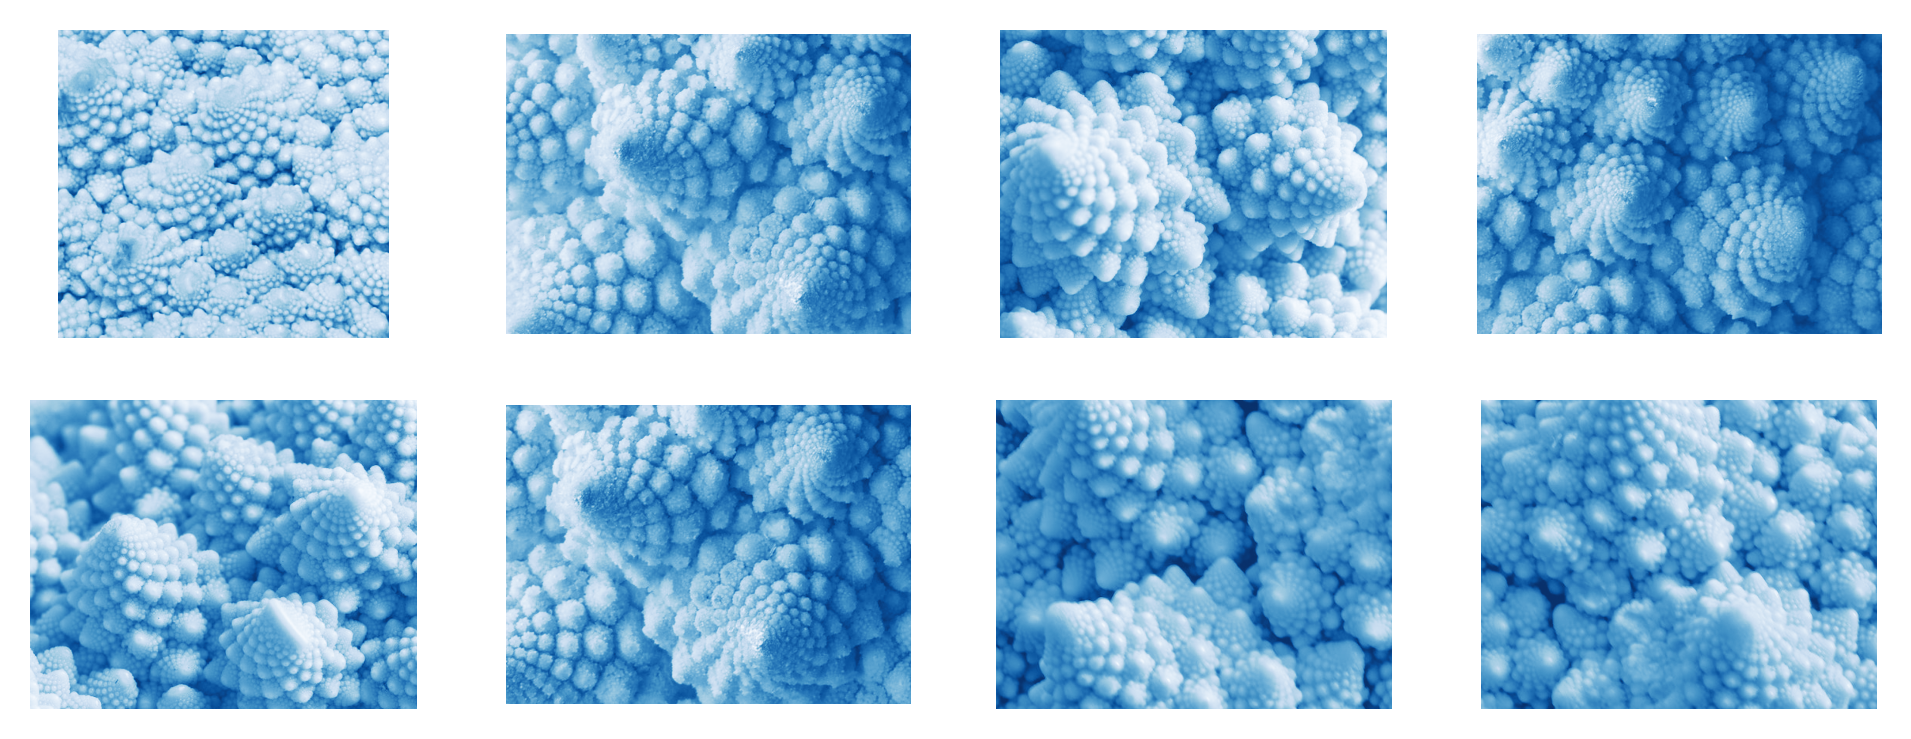

In [8]:
cauliflower_samples = blogutils.image_bootstrapper(CAULIFLOWERS_DIR)
blogutils.html_fig(
    blogutils.plot_samples(cauliflower_samples),
    '4.1.1', 'Cauliflower image samples', 'Unsplash'
)


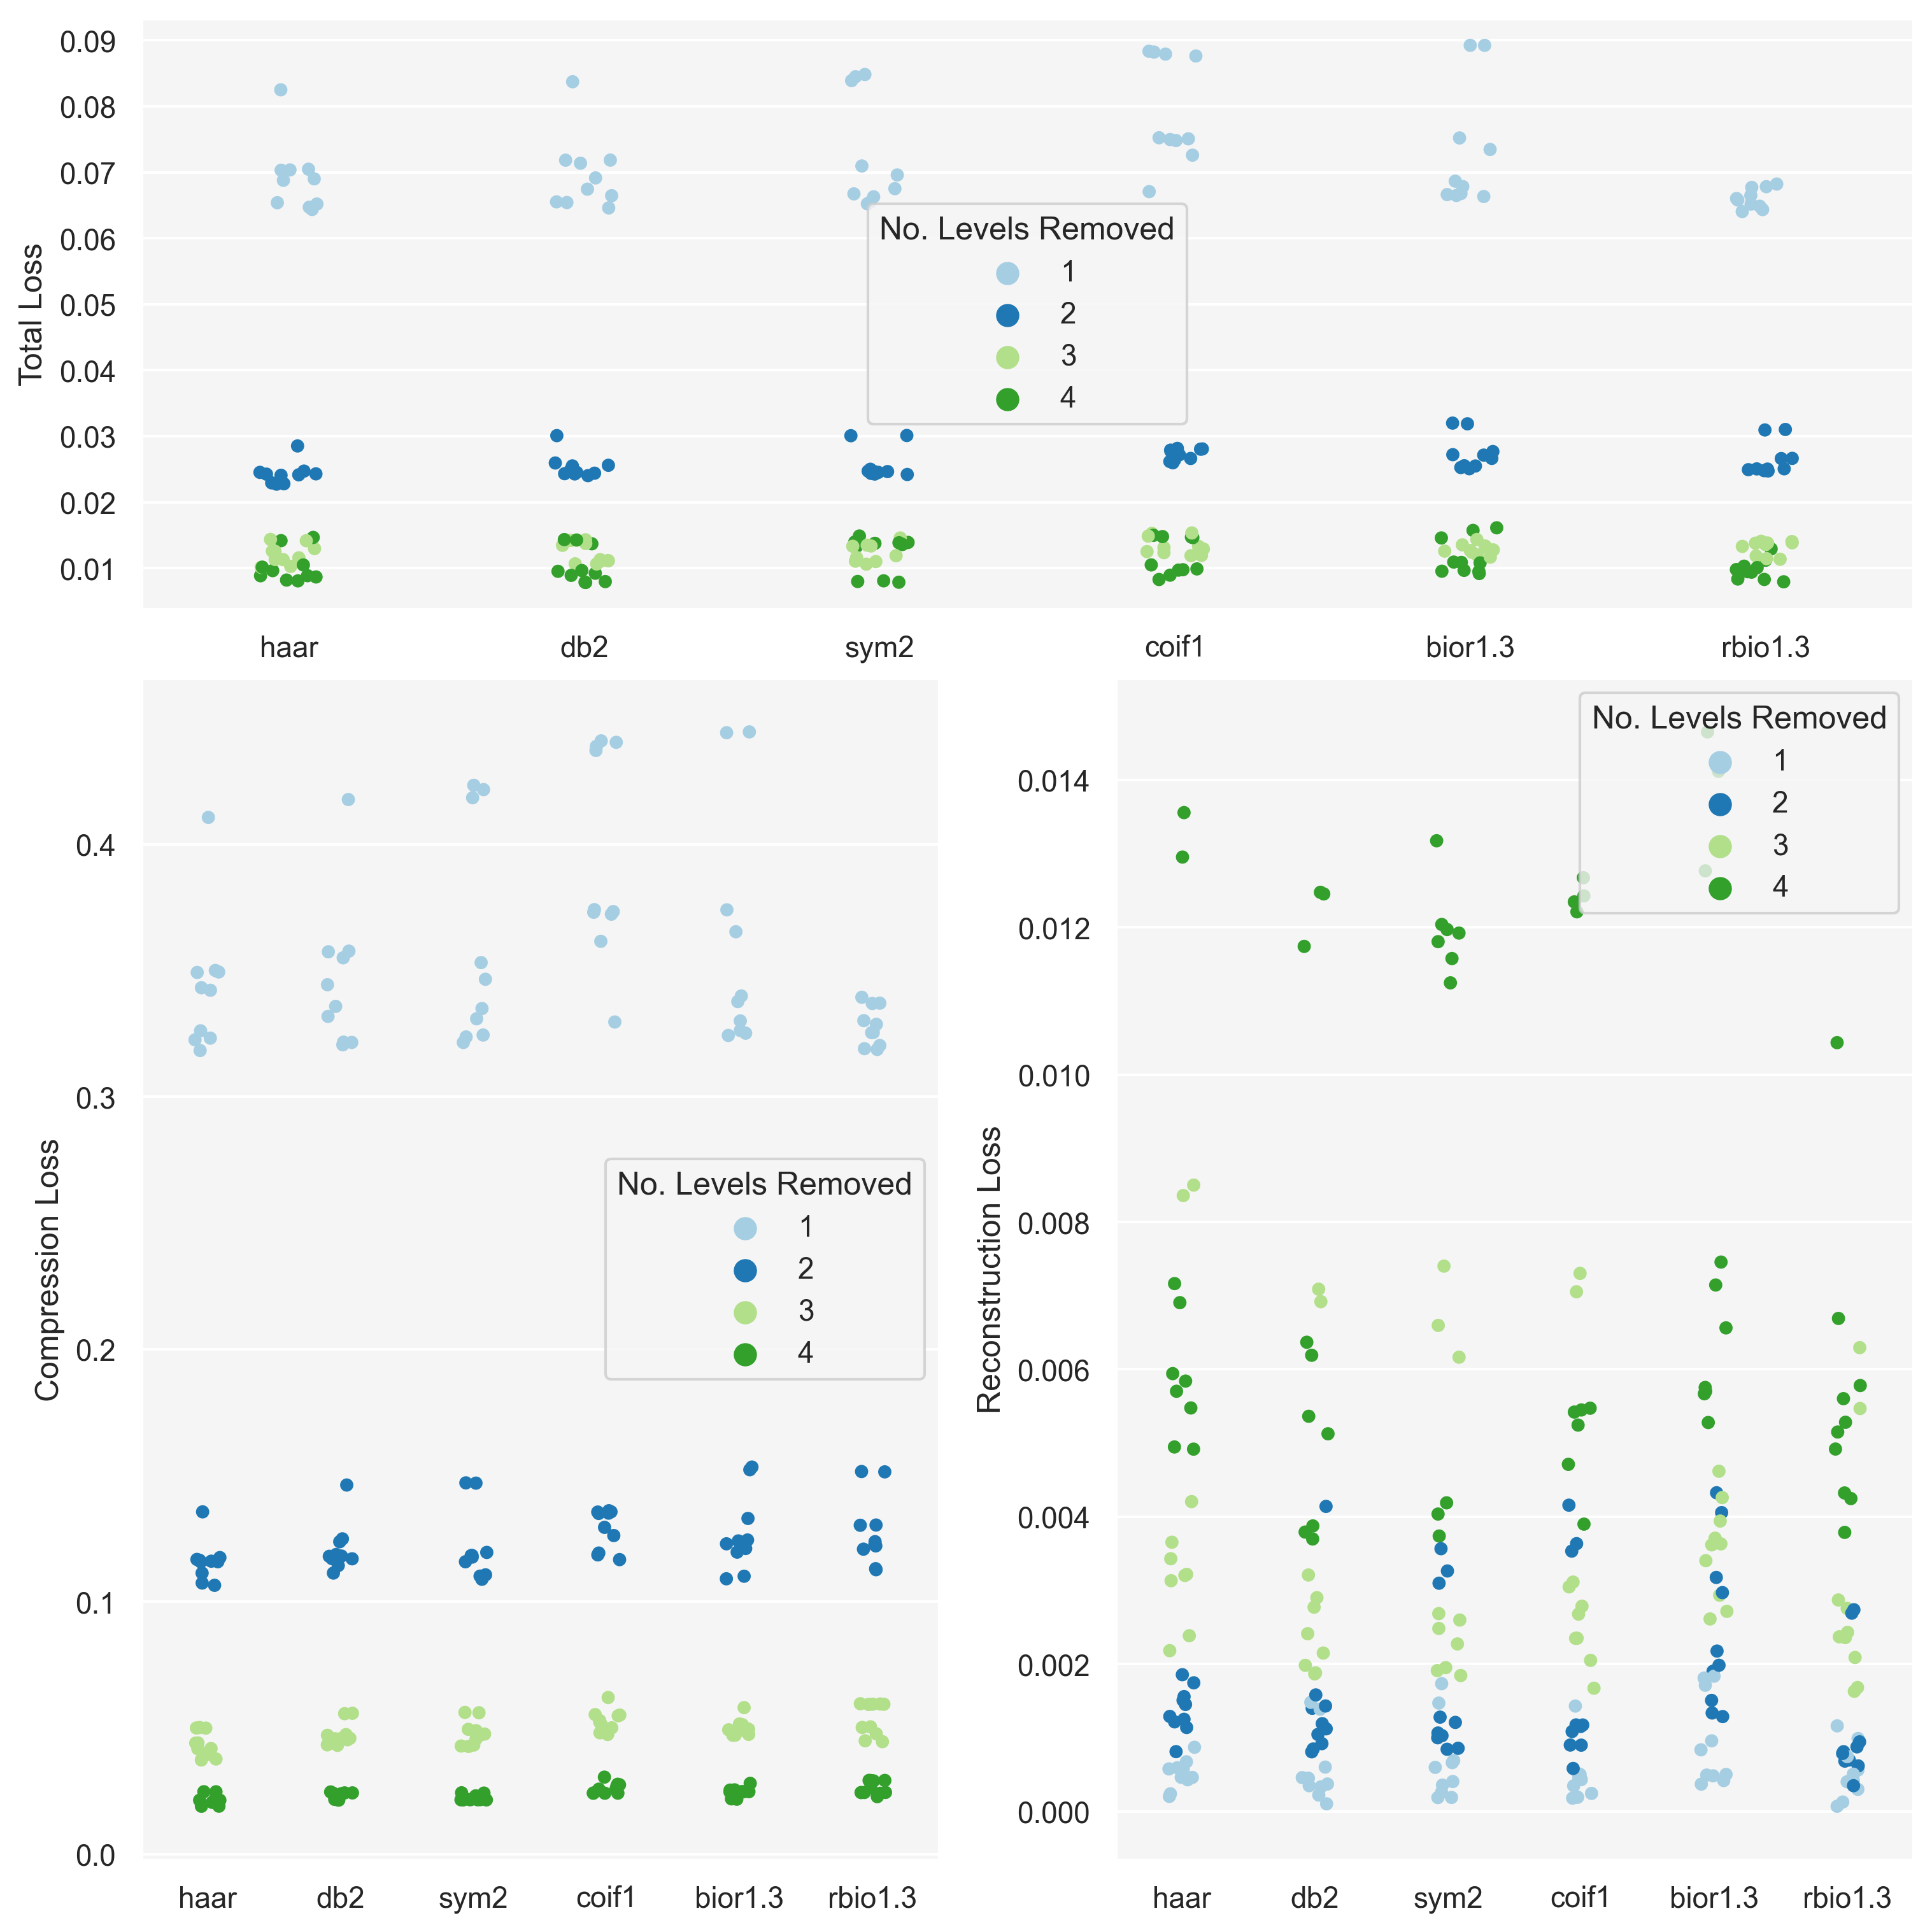

In [9]:
cauliflower_results = compare_wavelets(cauliflower_samples)
blogutils.html_fig(
    blogutils.plot_experiment_results(cauliflower_results),
    '4.1.2', 'Wavelet compression scoring results for the cauliflower image category', None
)

In [10]:
blogutils.html_df(
    blogutils.calculate_anova(cauliflower_results),
    '4.1.3', 'Type-II ANOVA of results for the cauliflower image category'
)

### Penrose Tilings

Penrose tilings were chosen as they have a large degree of regularity, and most of the information in them is localised around tile edges.


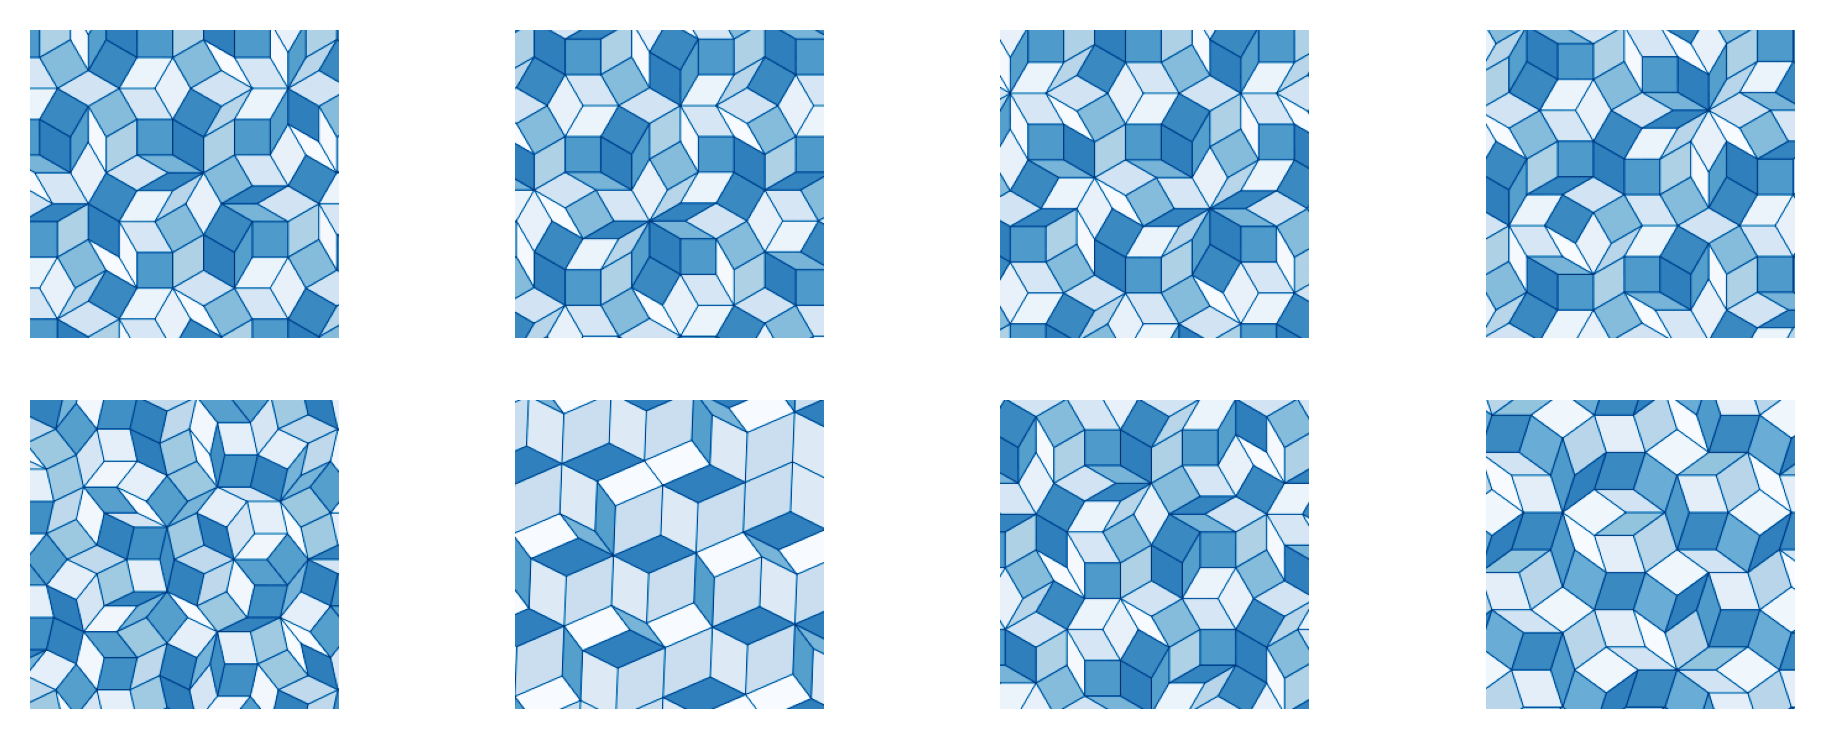

In [11]:
tiling_samples = blogutils.image_bootstrapper(TILINGS_DIR)
blogutils.html_fig(
    blogutils.plot_samples(tiling_samples),
    '4.2.1', 'Penrose tiling image samples',
)


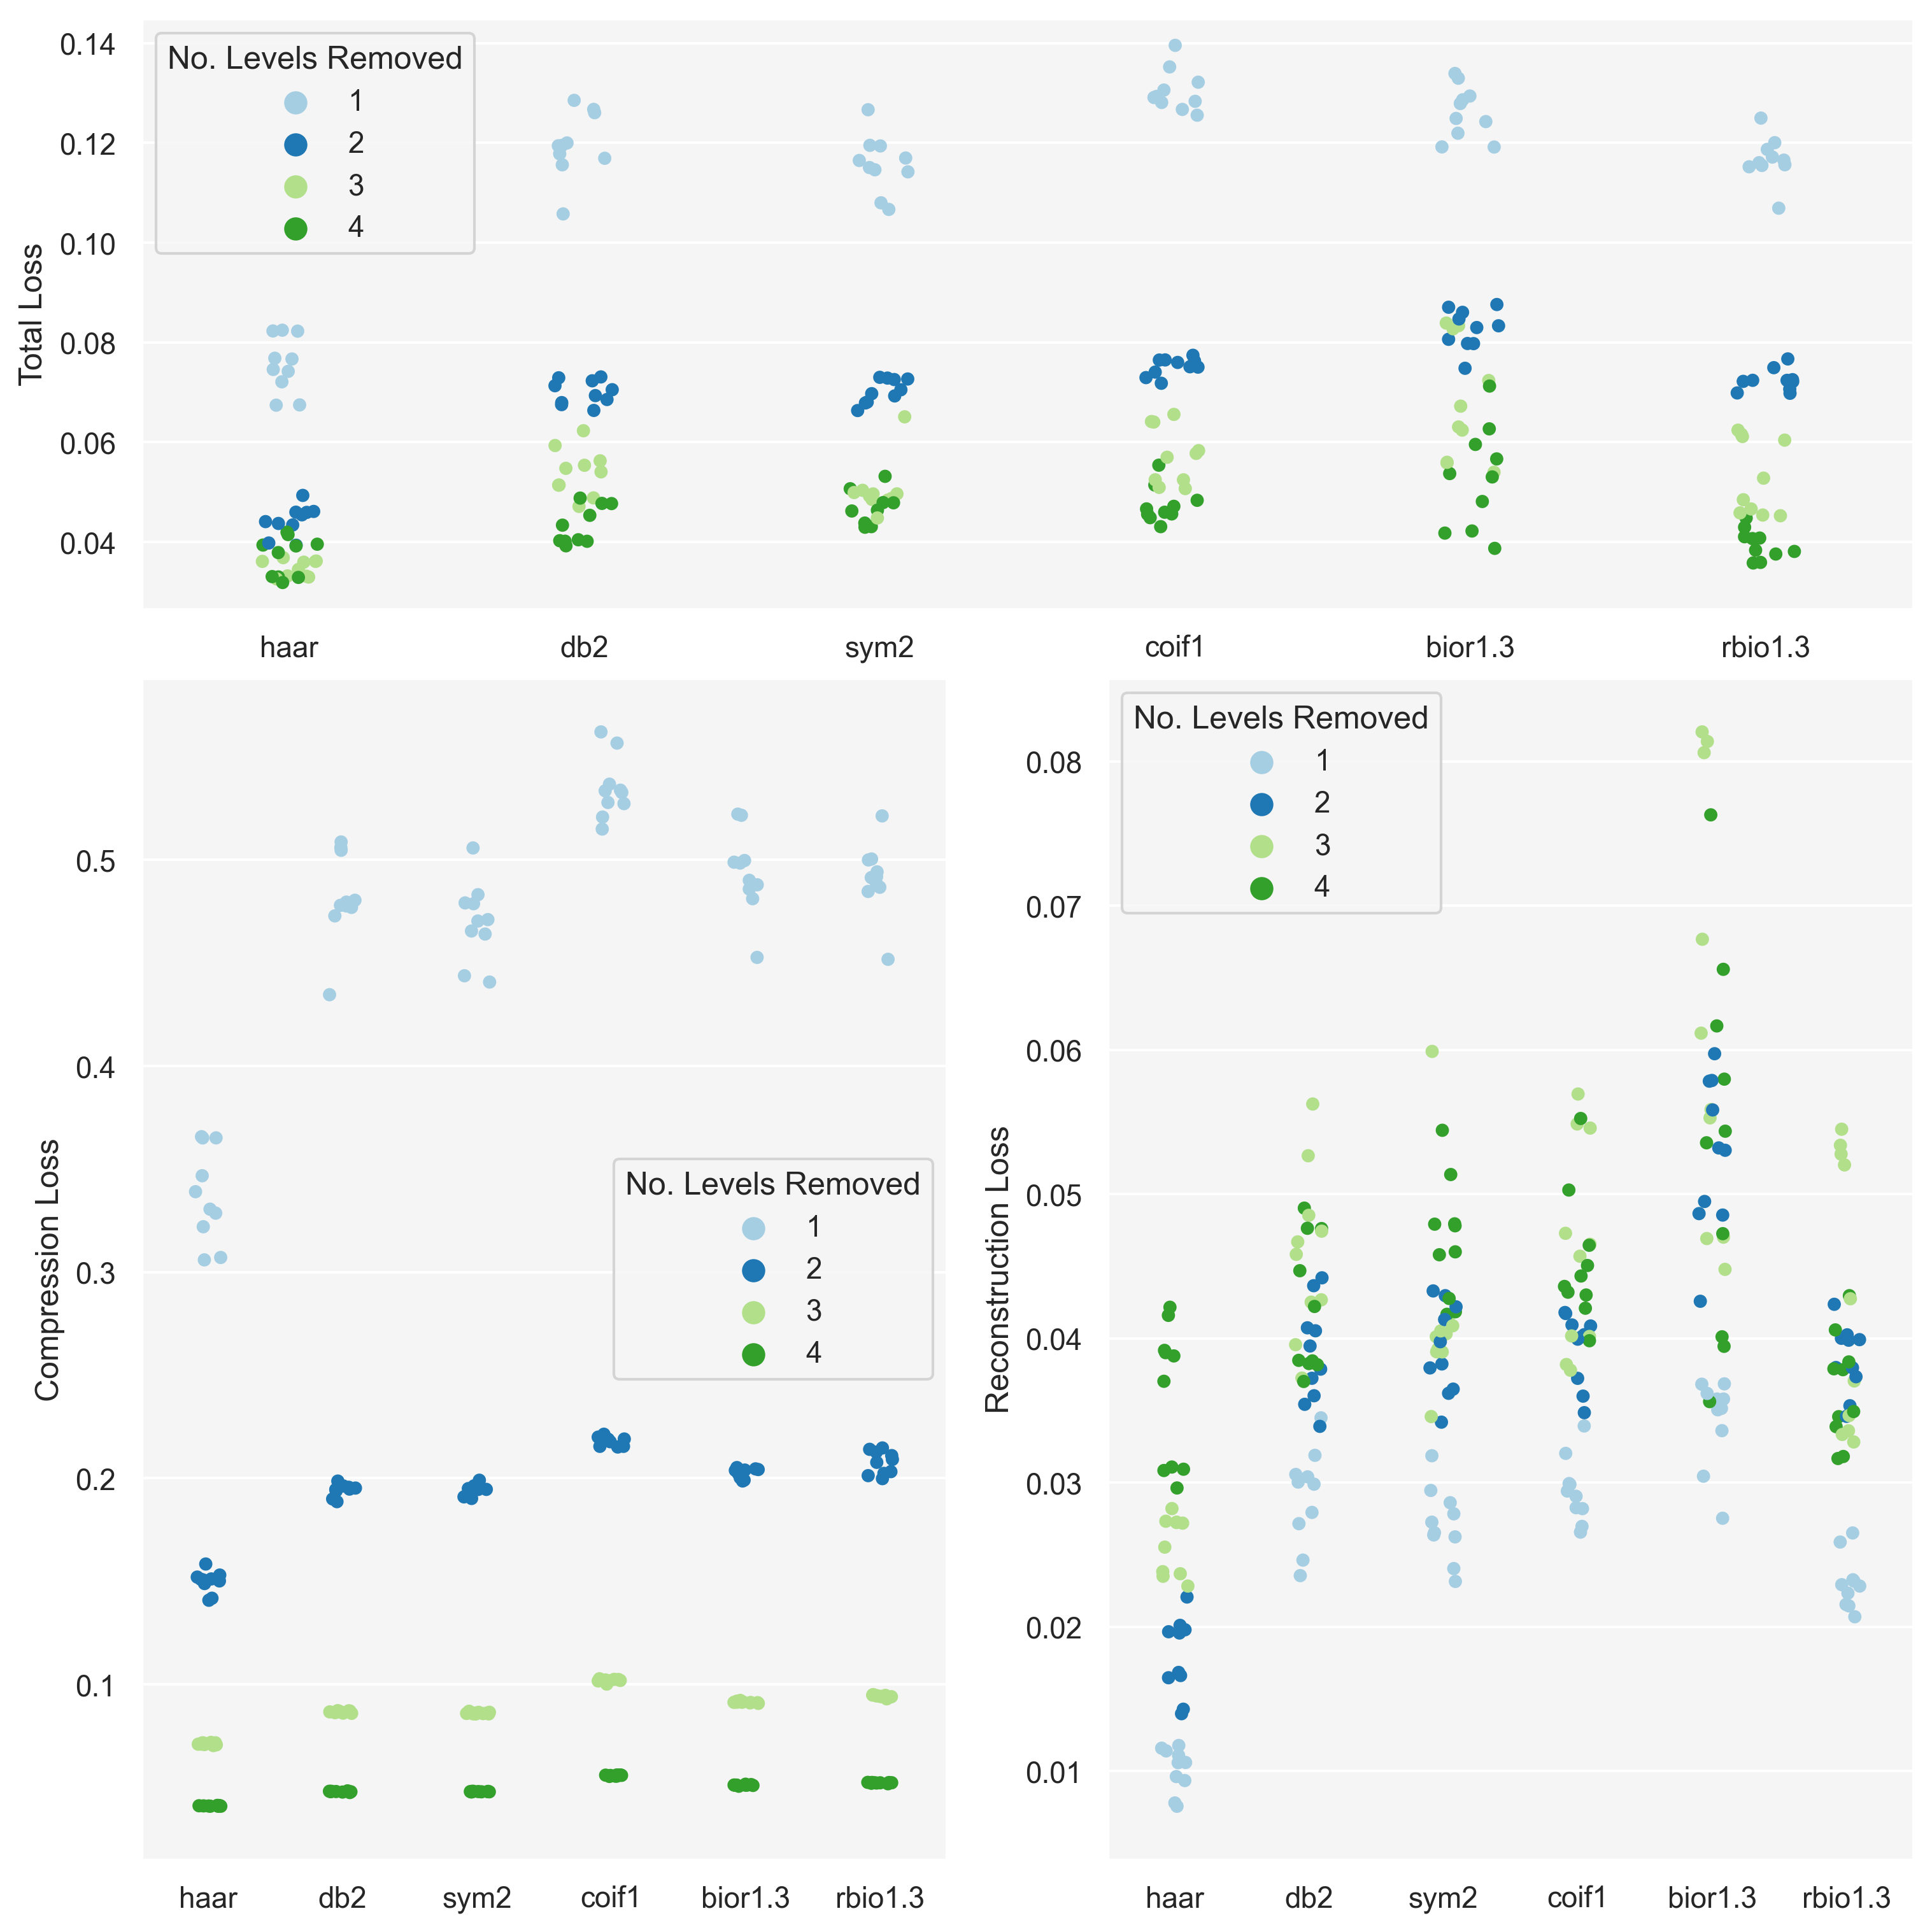

In [12]:
tiling_results = compare_wavelets(tiling_samples)
blogutils.html_fig(
    blogutils.plot_experiment_results(tiling_results),
    '4.2.2', 'Wavelet compression scoring results for the Penrose tile image category', None
)

In [13]:
blogutils.html_df(
    blogutils.calculate_anova(tiling_results),
    '4.2.3', 'Type-II ANOVA of results for the Penrose tiling image category'
)

### Caustics

Water caustics were chosen as, like the Penrose tilings, most of the information is concentrated around 'edges'. However, unlike the tilings, they have a much more organic structure, offering a nice comparison.


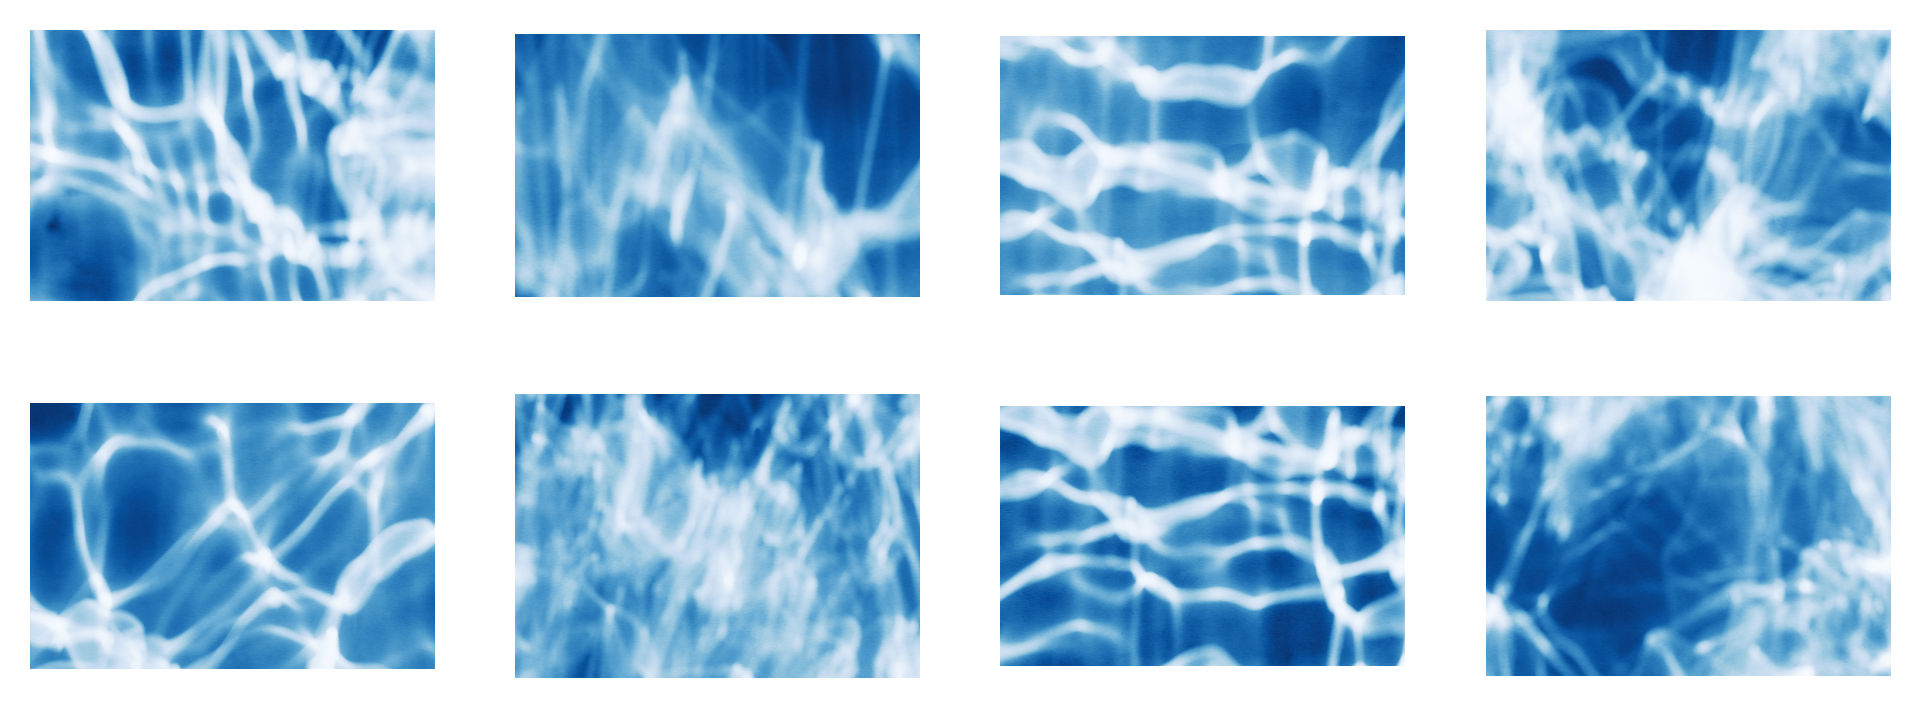

In [14]:
caustic_samples = blogutils.image_bootstrapper(CAUSTICS_DIR)
blogutils.html_fig(
    blogutils.plot_samples(caustic_samples),
    '4.3.1', 'Caustic image samples', 'Vecteezy'
)


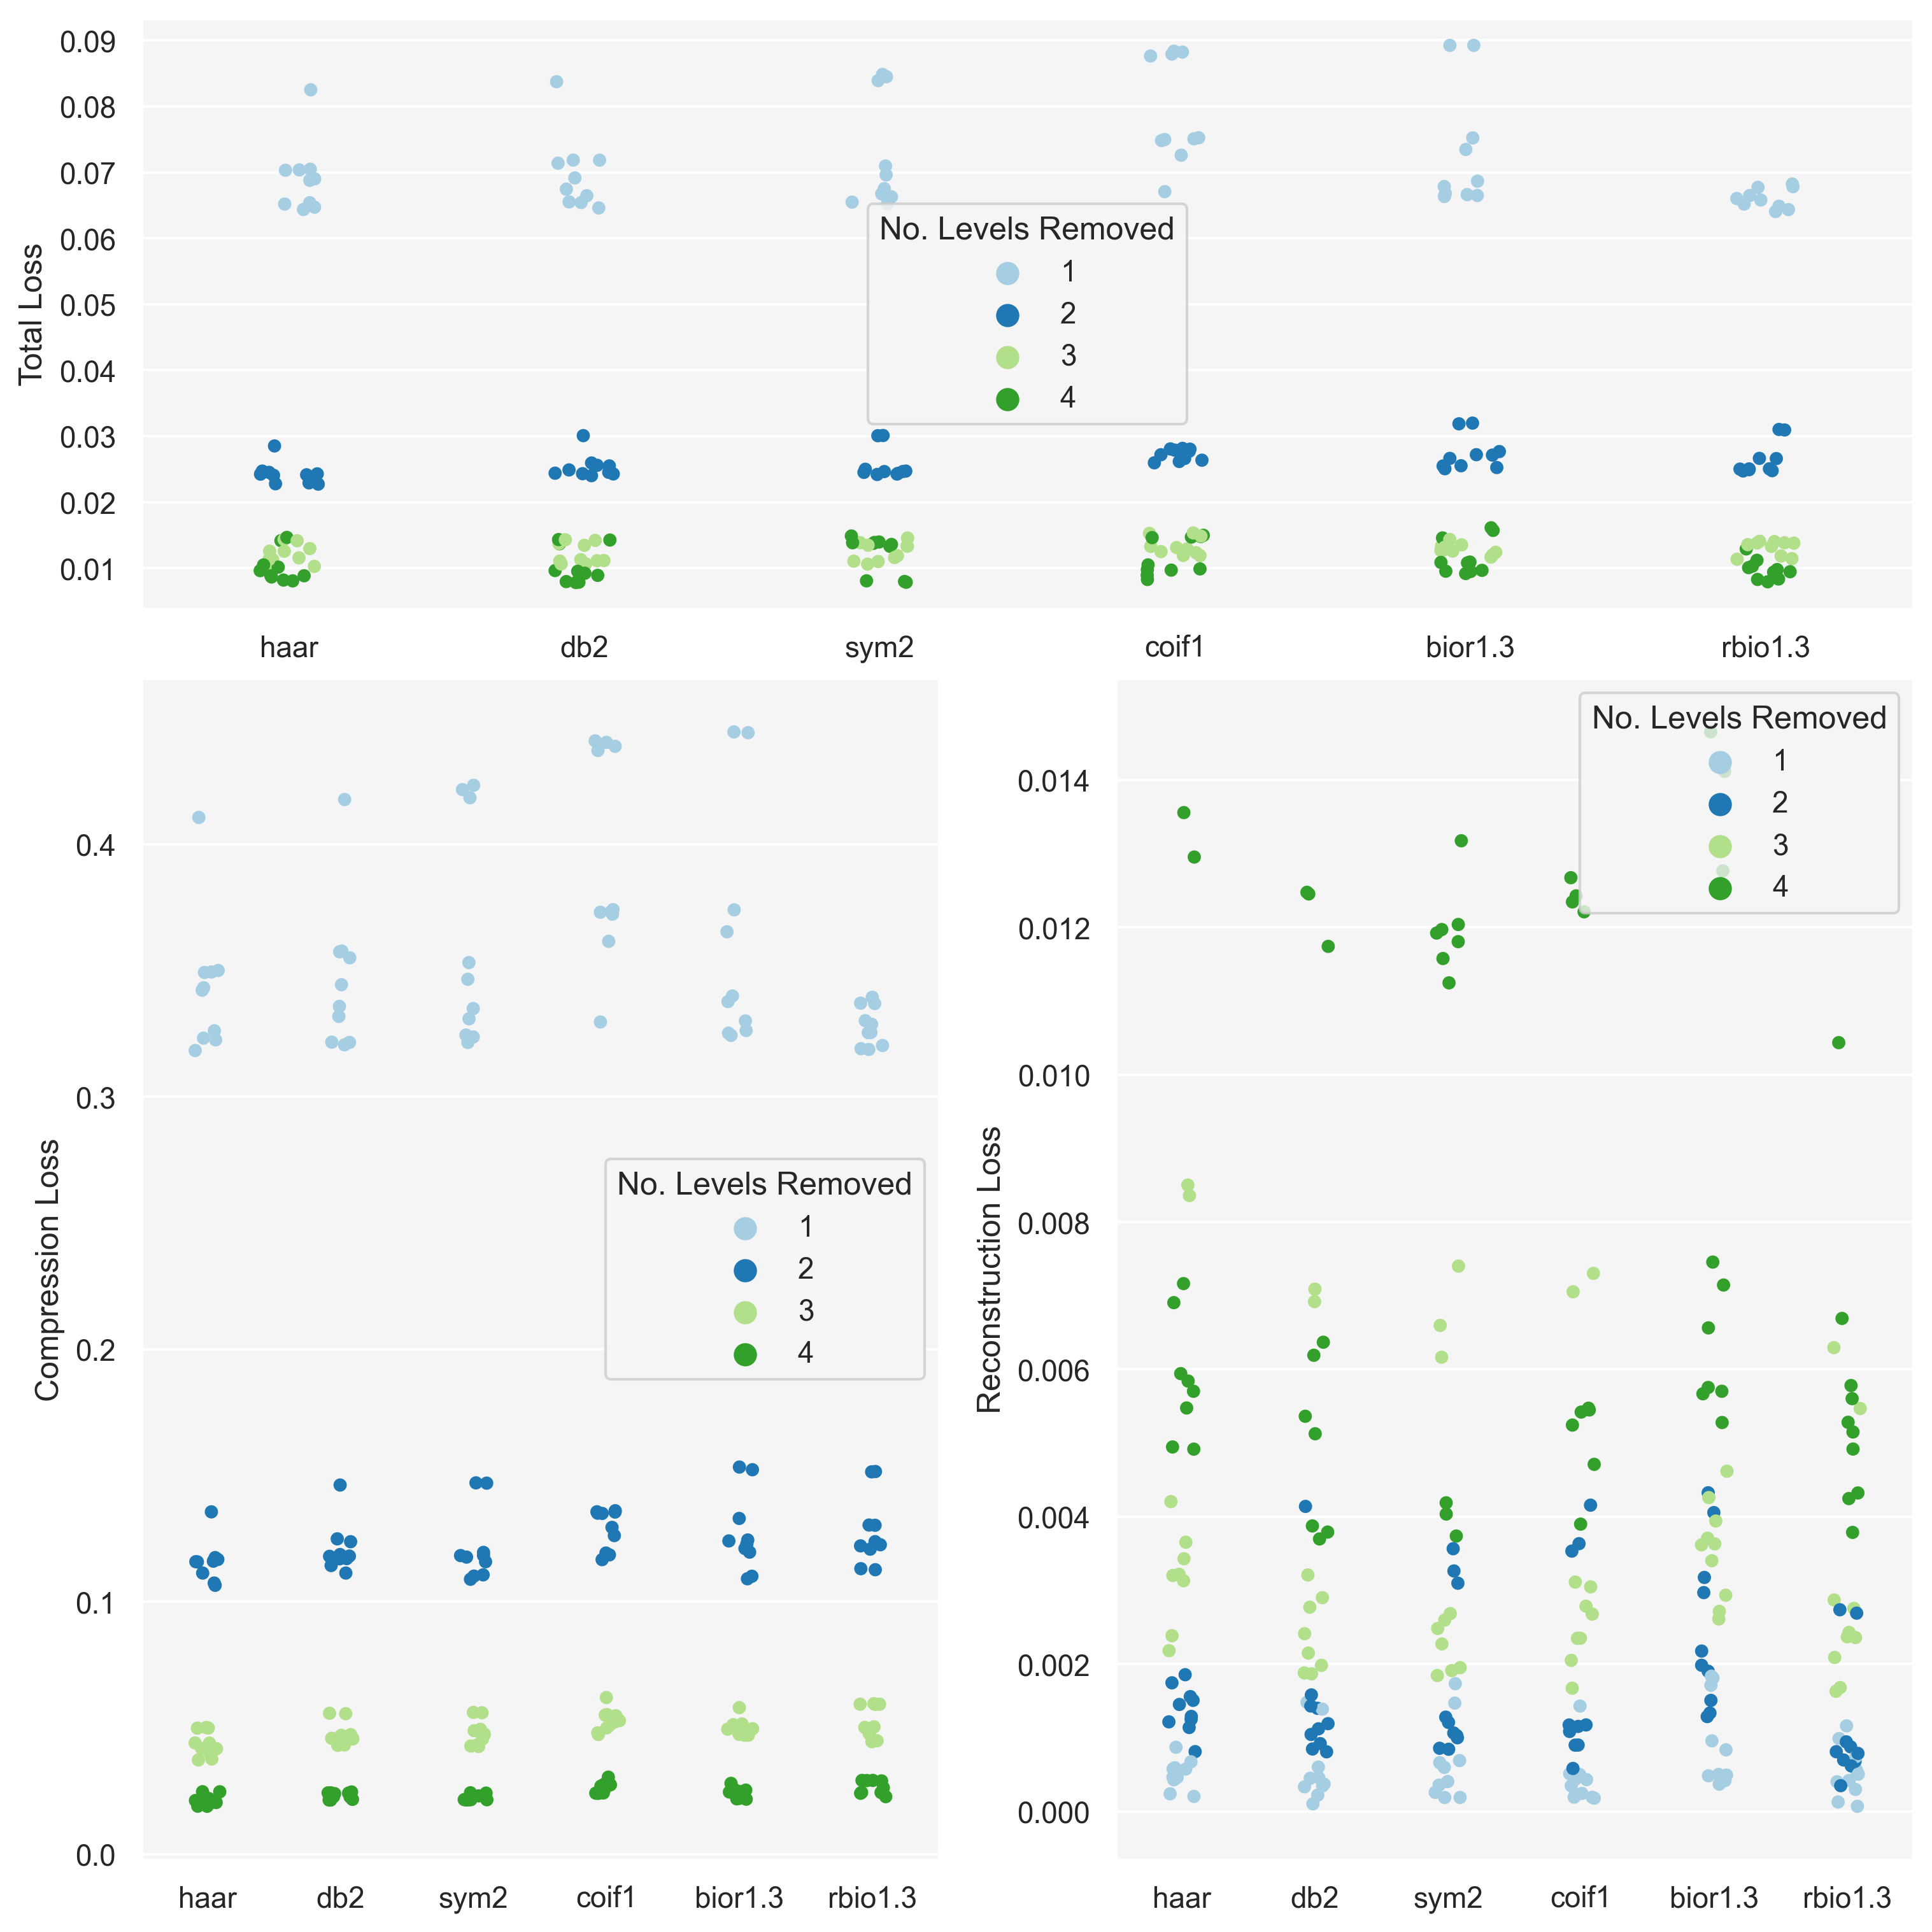

In [15]:
caustic_results = compare_wavelets(caustic_samples)
blogutils.html_fig(
    blogutils.plot_experiment_results(cauliflower_results),
    '4.3.2', 'Wavelet compression scoring results for the caustic image category', None
)

In [16]:
blogutils.html_df(
    blogutils.calculate_anova(cauliflower_results),
    '4.3.3', 'Type-II ANOVA of results for the caustic image category'
)

### Skylines

City skylines were chosen because the have a fractal-like composition but, more importantly, they have an asymmetry along the vertical axis - which is a quality the other image categories do not have.


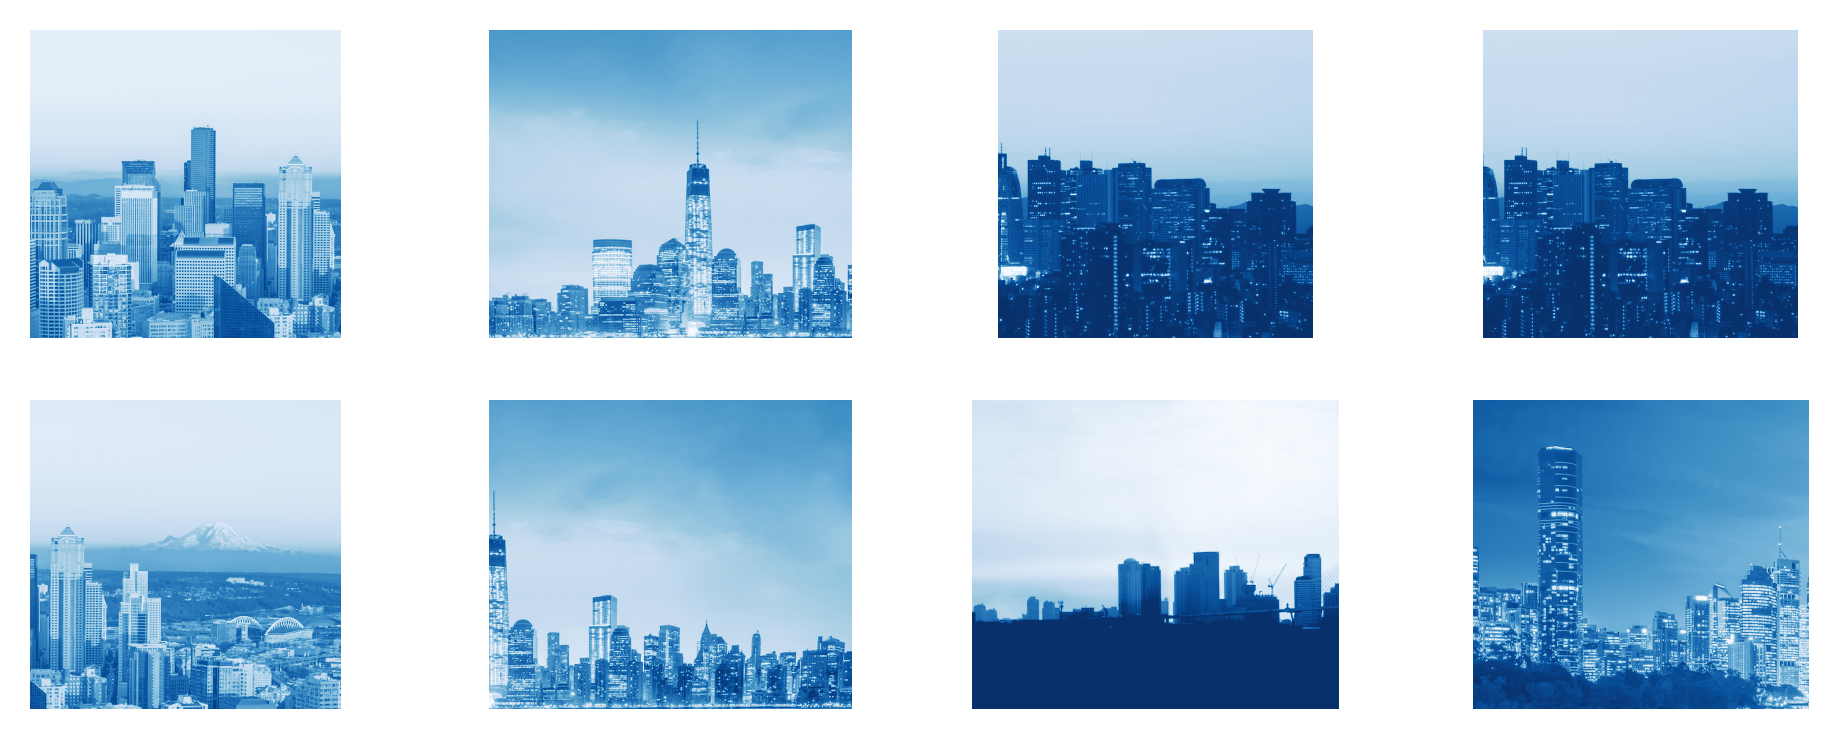

In [17]:
skyline_samples = blogutils.image_bootstrapper(SKYLINES_DIR, y_crop=1.0)
blogutils.html_fig(
    blogutils.plot_samples(skyline_samples),
    '4.4.1', 'Skyline image samples'
)


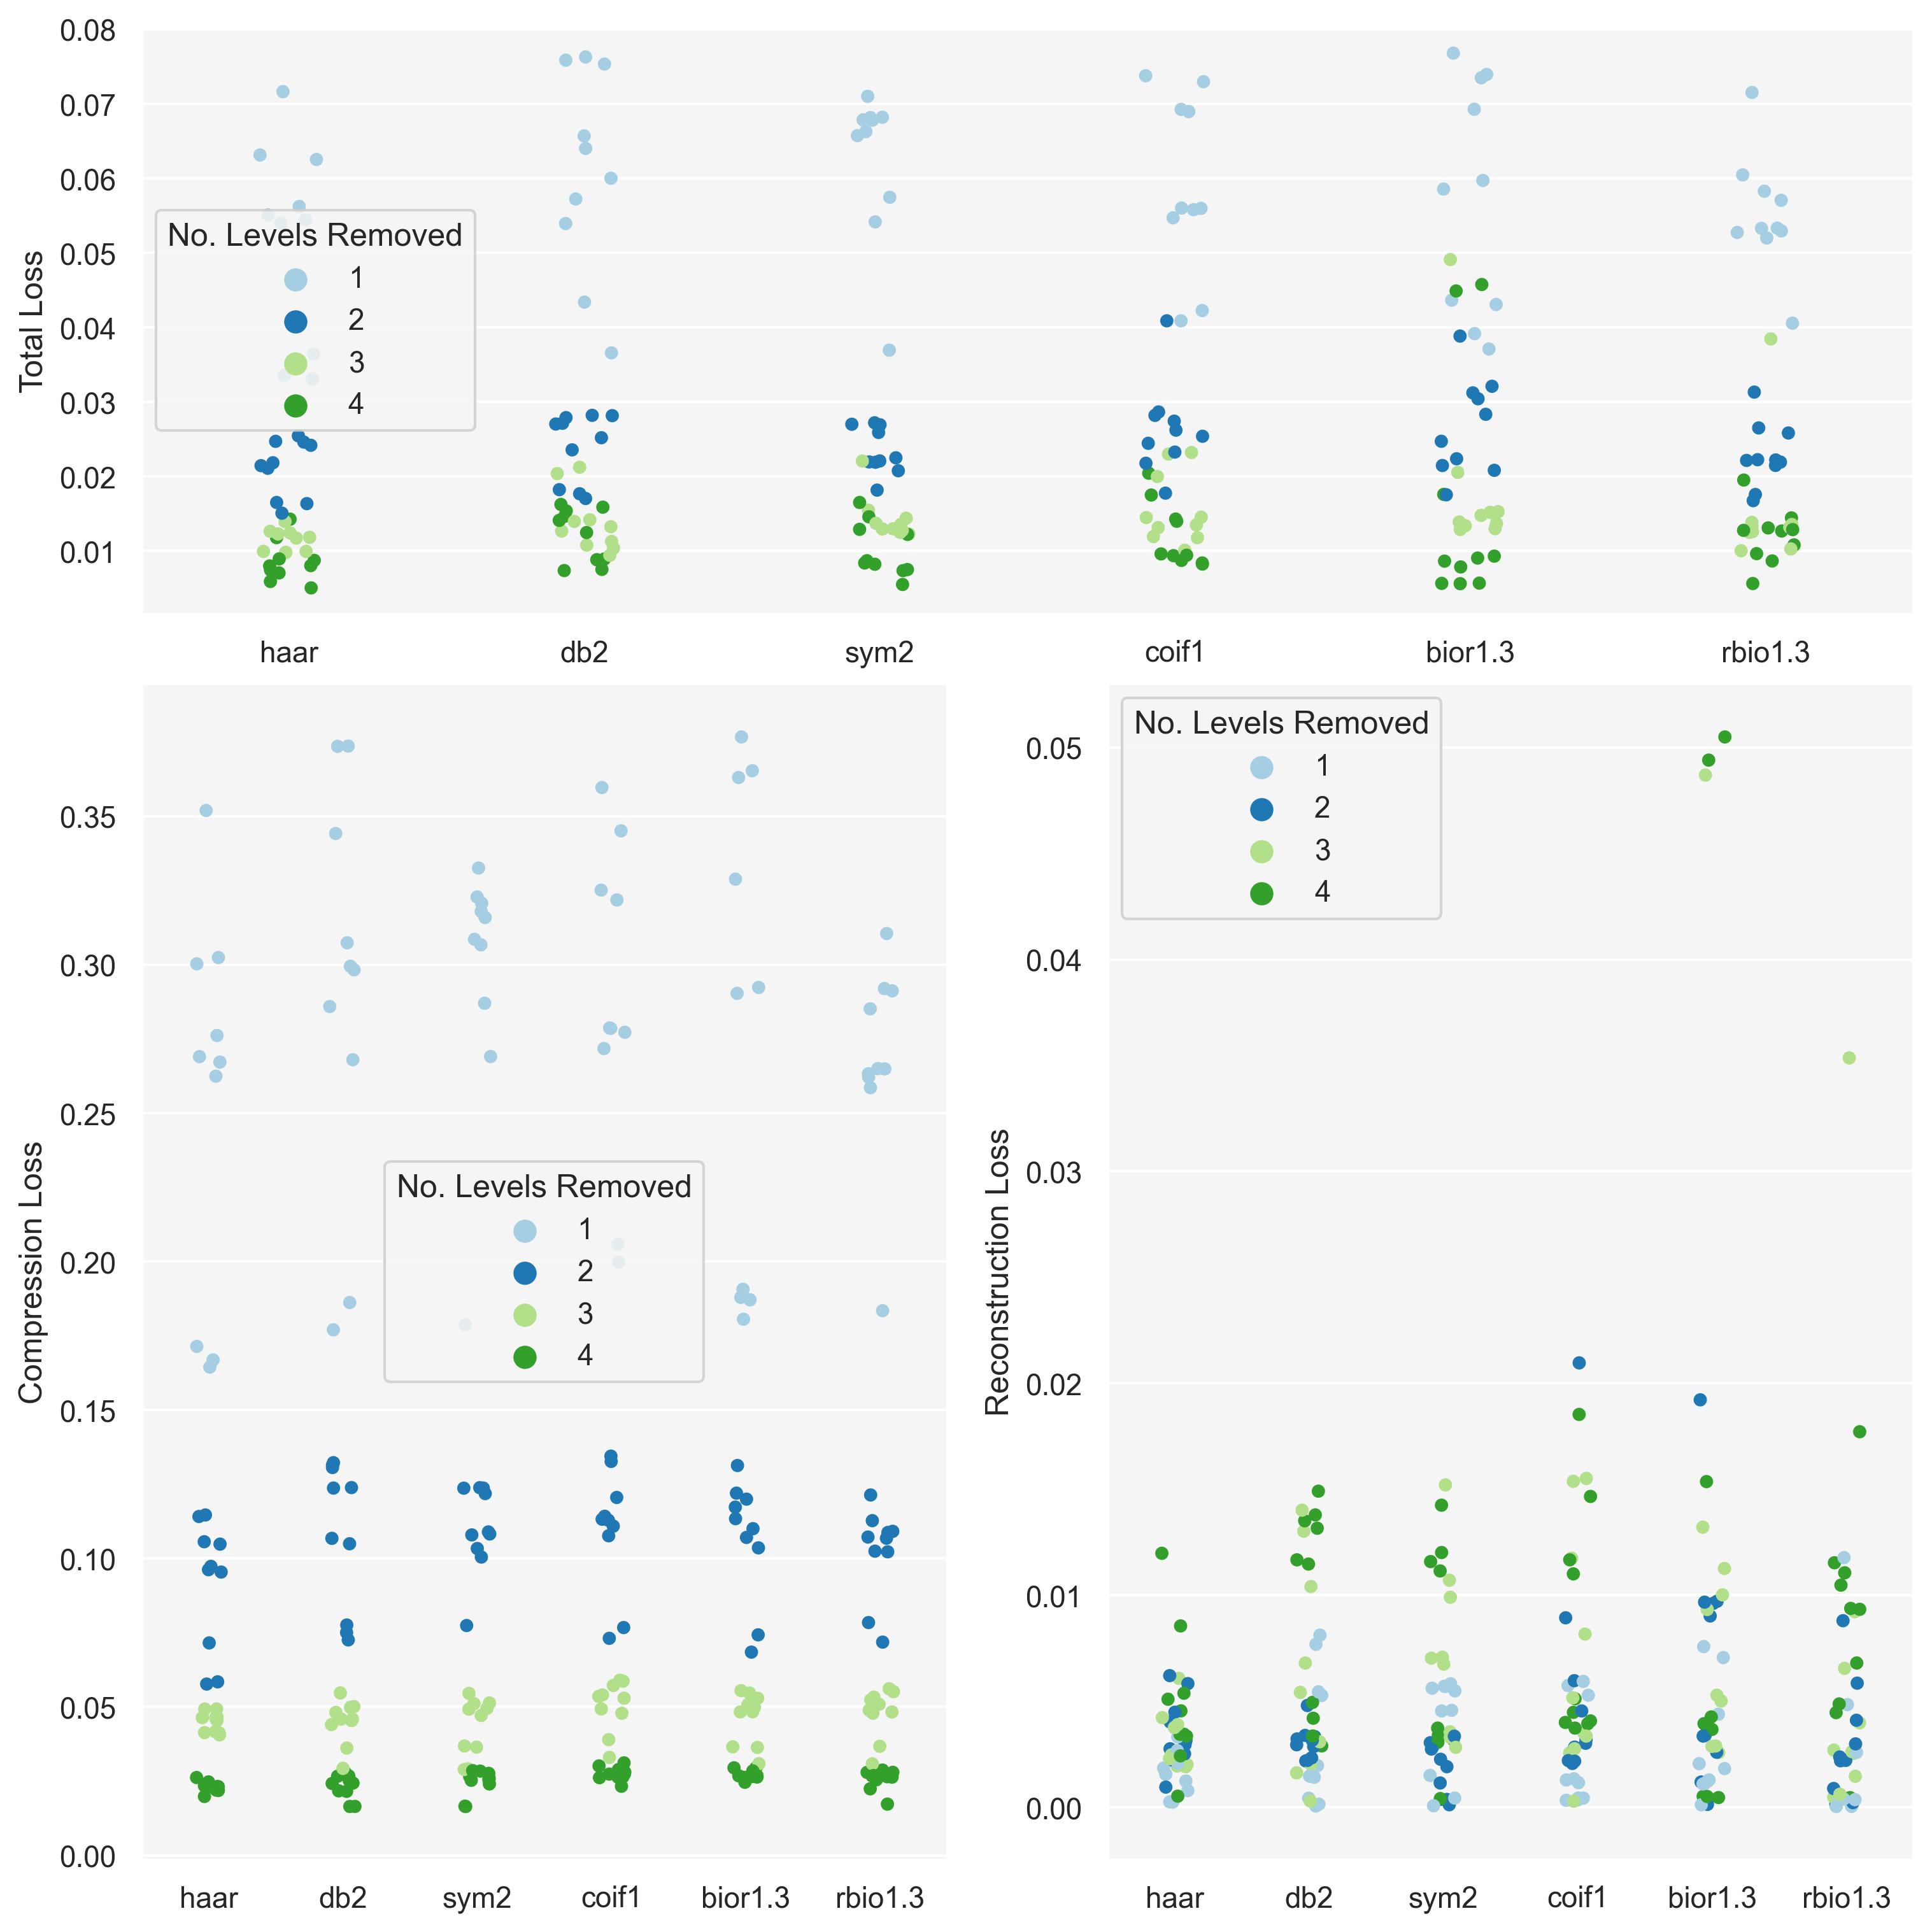

In [18]:
skyline_results = compare_wavelets(skyline_samples)
blogutils.html_fig(
    blogutils.plot_experiment_results(skyline_results),
    '4.4.2', 'Wavelet compression scoring results for the skyline image category', None
)

In [19]:
blogutils.html_df(
    blogutils.calculate_anova(cauliflower_results),
    '4.4.3', 'Type-II ANOVA of results for the skyline image category'
)

## Part 5: Analysis

Interestingly, in the end, it was only the Penrose tilings that showed a significant variation between wavelet families:

|  Category | p-value  |
|---|---|
|  Cauliflowers |  0.994076 |
|  Penrose Tilings | 0.000004  |
|  Caustics | 0.993114  |
|  Skylines | 0.885055  |

By looking at the graph for the tilings we see that this variation was primarily in the reconstruction loss - however the compression loss did appear to show some small degree of variation too.

Even though p-values were highly insignificant for the other image categories the graphs do indicate that there is some interplay between image category, wavelet family, and resolution. However it is not clear to me how to tease this out in a meaningful experiment.

I imagine that a better way to make decisions on this would be to have a large number of examples of your data up-front, and run some kind of cross-validation selection based on your own tuned scoring criteria.

However, the fact that Penrose tilings showed the most significant variation suggests that images with high levels of regularity may benefit from a decomposition of this form, and that further experiments could identify the exact reason for the significance.

Another area we could improve this experiment is to build our scoring criteria based on 'energy'. At the moment, to compress the image we're just slicing off whole layers of image resolution, however instead we could maybe iterate over the coefficients, selecting those that account for the most information first until we hit some stopping criteria, and then form a statistic based on how soon we stop.

## Conclusion

We can conclude from this simple experiment that the exact time and place to use wavelets isn't absolutely clear - at least not for image compression.

Looking around at other papers, such as (Oliveira et al., 2019)[5] which details the use of wavelets in power-grid signal analysis, there are a great number of recent studies which claim to find benefit in their use. So perhaps the value lies in more esoteric examples. (I suppose that even within this experiment we did at least see one area of benefit, which indicates that the tool could be valuable for specific signal types).

That said though, from this investigation, I still could not point to a signal and have a strong intuition as to whether wavelets would provide a good compression mechanism.

There's much more investigating to be done.

## Bibliography

1. Graps, A. (1995). An introduction to wavelets. IEEE Computational Science and Engineering, 2, 50–61.
2. Daubechies, I. (1996). Where do wavelets come from? A personal point of view. Proceedings of the IEEE, 84(4), 510–513. https://doi.org/10.1109/5.488696
3. Mallat, S. G. (1989). A theory for multiresolution signal decomposition: The wavelet representation. IEEE Transactions on Pattern Analysis and Machine Intelligence, 11(7), 674–693. https://doi.org/10.1109/34.192463
4. Gregory R. Lee, Ralf Gommers, Filip Wasilewski, Kai Wohlfahrt, Aaron O’Leary (2019). PyWavelets: A Python package for wavelet analysis. Journal of Open Source Software, 4(36), 1237, https://doi.org/10.21105/joss.01237.
5. Oliveira, M. O., Reversat, J. H., & Reynoso, L. A. (2019). Wavelet Transform Analysis to Applications in Electric Power Systems. In Wavelet Transform and Complexity. IntechOpen. https://doi.org/10.5772/intechopen.85274

## Image Attributions

- **Caustics & City Skylines**:
    - <a href="https://www.vecteezy.com/free-photos">Free Stock photos by Vecteezy</a>
- **Fractal Cauliflowers**:
    - All courtesy of <a href="https://unsplash.com/s/photos/fractal-cauliflower?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
    - Specific photographers: <a href="https://unsplash.com/@stevenlasry?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Steven Lasry</a>, <a href="https://unsplash.com/@yogidan2012?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Daniele Levis Pelusi</a>, <a href="https://unsplash.com/@jean_mi_g?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Jean-Michel GARCIA</a>, <a href="https://unsplash.com/@patrickperkins?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Patrick Perkins</a>

## Links

<a class="github-link" href="https://github.com/teaochablog/comparing-wavelets-for-image-compression">View this notebook on GitHub</a>